In [2]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import gc
mpl.style.use('pof')
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
def load_object(filename):
    with open(filename, 'rb') as input:  # Overwrites any existing file.
        obj = pickle.load(input)
    return obj

In [2]:
from scipy.interpolate import griddata
from scipy.signal import hilbert

from scipy.signal import butter,filtfilt
# Filter requirements.
def butter_lowpass_filter(data, CUT=4):
    T = 4     # Sample Period
    fs = 512/T      # Sample rate, Hz
    cutoff = CUT    # desired cutoff frequency of the filter, Hz, slightly higher than actual 1.2 Hz
    nyq = 0.5 * fs  # Nyquist Frequency
    order = 2       # sin wave can be approx represented as quadratic
    n = int(T * fs) # total number of samples
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

class Snapshot:
    '''
    Class for every snapchat
    self.availt: The longest running time
    self.path: Path of the case file
    
    '''  
    def __init__(self, t, working_dir, NSLICE=256, NGRID=256, L0=np.pi*2, trans=False, PRUNING=True):
        '''
        trans: if phase shift is needed
        self.eta_raw: raw x,z,eta data
        self.eta_tile,self.x_tile,self.z_tile: interpolated eta,x,z with resolution specified by NGRID
        self.eta_1D: eta averaged over z direction
        '''
        self.t = t
        # Declare the fields (do not store as class attribution because of memory issues)
        ux_3D = {'name':'ux', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
        uy_3D = {'name':'uy', 'value':[]}
        # Read in the fields
        for field in (ux_3D,uy_3D):
            for sn in range (0,NSLICE-1):
                filename = working_dir + 'field/'+field['name']+'_t%g_slice%g' % (self.t,sn)
                snapshot = np.loadtxt(filename, dtype = np.str, delimiter='\t')
                snapshot.reshape([NGRID,NGRID+1])
                field['value'].append(snapshot[:,0:NGRID].astype(np.float))
            field['value'] = np.array(field['value'])
        # Read in eta
        filename = working_dir + 'eta/eta_t%g' % self.t
        snapshot = pd.read_table(filename, delimiter = ',')
        if PRUNING:
            snapshot = snapshot[snapshot.x != 'x']
            snapshot = snapshot.astype('float')
            snapshot = snapshot[snapshot.pos < 1 + 0.4/4]
        self.eta_raw = {'x':np.array(snapshot.x), 'z':np.array(snapshot.z), 'eta':np.array(snapshot.pos)}
        del (snapshot)
        gc.collect()
        # Interpolate over x-z plane with the same resolutions
        xarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
        zarray = np.linspace(-L0/2.,L0/2,NGRID,endpoint=False)+L0/NGRID/2
#         xarray = np.linspace(-L0/2,L0/2,NGRID); zarray = np.linspace(-L0/2,L0/2,NGRID)
        self.x_tile, self.z_tile = np.meshgrid(xarray,zarray)
        self.eta_tile = griddata((self.eta_raw['x'].ravel(), self.eta_raw['z'].ravel()), self.eta_raw['eta'].ravel(), 
                                 (self.x_tile, self.z_tile), method='nearest')
        # !To-dos: test for non quasi 1D cases
        self.eta_1D = np.average(self.eta_tile, axis=0)
        # Compute the Reynolds stress
        self.ux_1D = np.average(ux_3D['value'], axis=(0,1))
        self.uy_1D = np.average(uy_3D['value'], axis=(0,1))
        ux_1D_broadcast = np.tile(self.ux_1D, (NSLICE-1, NGRID, 1))
        uy_1D_broadcast = np.tile(self.uy_1D, (NSLICE-1, NGRID, 1))
        re_stress_3D = (ux_3D['value']-ux_1D_broadcast)*(uy_3D['value']-uy_1D_broadcast)
        # Include only z direction averaged 2D profile
        self.ux_2D = np.average(ux_3D['value'], axis=0)
        self.uy_2D = np.average(uy_3D['value'], axis=0)
        self.re_stress_2D = np.average(re_stress_3D,axis=0)    
        del (re_stress_3D)
        gc.collect()        
        # Hilbert transform, performed along x        
        # Filter the data (subtract the mean)
        if trans == True:
            self.eta_1D_filtered = butter_lowpass_filter(self.eta_1D-np.average(self.eta_1D))
            analytic_signal = hilbert(self.eta_1D_filtered)
            self.phase = np.angle(analytic_signal)
            # Shift the velocity field along x axis so that phase starts at 0
            self.idx = (np.abs(self.phase - 0)).argmin()
#             self.eta_1D_shift = np.roll(self.eta_1D, -self.idx)
#             self.ux_2D = np.roll(self.ux_2D, -self.idx)
#             self.uy_2D = np.roll(self.uy_2D, -self.idx)
#             self.re_stress_2D = np.roll(self.re_stress_2D, -self.idx)
#             self.ux_3D_shift = {'name':'ux_shift', 'value':[]} # axis0 in z, axis1 in x, axis2 in y  (in the code)
#             self.uy_3D_shift = {'name':'uy_shift', 'value':[]}
#             for (field,field_shift) in zip((self.ux_3D,self.uy_3D),(self.ux_3D_shift,self.uy_3D_shift)):
#                 field_shift['value'] = np.roll(field['value'], -self.idx, axis=1)


In [11]:
dirname = '/home/jiarong/research/projects/turbulence/curved_fixREtau_precursor_REtau720_ak0.2_LEVEL10_emax0.3/'
snapshot_ensemble_720_pre = []
for i in tqdm(range(0,6)):
    t = 54 + i
    snapshot = Snapshot(t, working_dir=dirname, NSLICE=256, NGRID=512, L0=2*np.pi, PRUNING=False)
    snapshot_ensemble_720_pre.append(snapshot)

100%|██████████| 6/6 [08:49<00:00, 88.19s/it]


In [3]:
dirname = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g1_ak0.2_MU16_LEVEL10_emax0.3/'
snapshot_ensemble_720_moving_g1 = []
for i in tqdm(range(0,10)):
    t = 57 + i*2
    snapshot = Snapshot(t, working_dir=dirname, NSLICE=256, NGRID=512, L0=2*np.pi)
    snapshot_ensemble_720_moving_g1.append(snapshot)

 60%|██████    | 6/10 [08:48<05:50, 87.71s/it]/home/jiarong/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
100%|██████████| 10/10 [14:40<00:00, 88.07s/it]


In [4]:
dirname = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau720_BO200_g4_ak0.2_MU8_LEVEL10_emax0.3/'
snapshot_ensemble_720_moving_g4 = []
for i in tqdm(range(0,8)):
    t = 57 + i*2
    snapshot = Snapshot(t, working_dir=dirname, NSLICE=256, NGRID=512, L0=2*np.pi)
    snapshot_ensemble_720_moving_g4.append(snapshot)

 12%|█▎        | 1/8 [01:22<09:38, 82.65s/it]/home/jiarong/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (0,1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
100%|██████████| 8/8 [11:09<00:00, 83.73s/it]


In [12]:
save_object(snapshot_ensemble_720_pre, 'ensem_720_pre.pkl')

In [4]:
save_object(snapshot_ensemble_720_moving_g1, 'ensem_720_g1.pkl')

In [8]:
snapshot_ensemble_720_moving_g1 = load_object('ensem_720_g1.pkl')
snapshot_ensemble_720_moving_g4 = load_object('ensem_720_g4.pkl')
snapshot_ensemble_720_pre = load_object('ensem_720_pre.pkl')

No handles with labels found to put in legend.


(-0.2, 1.5)

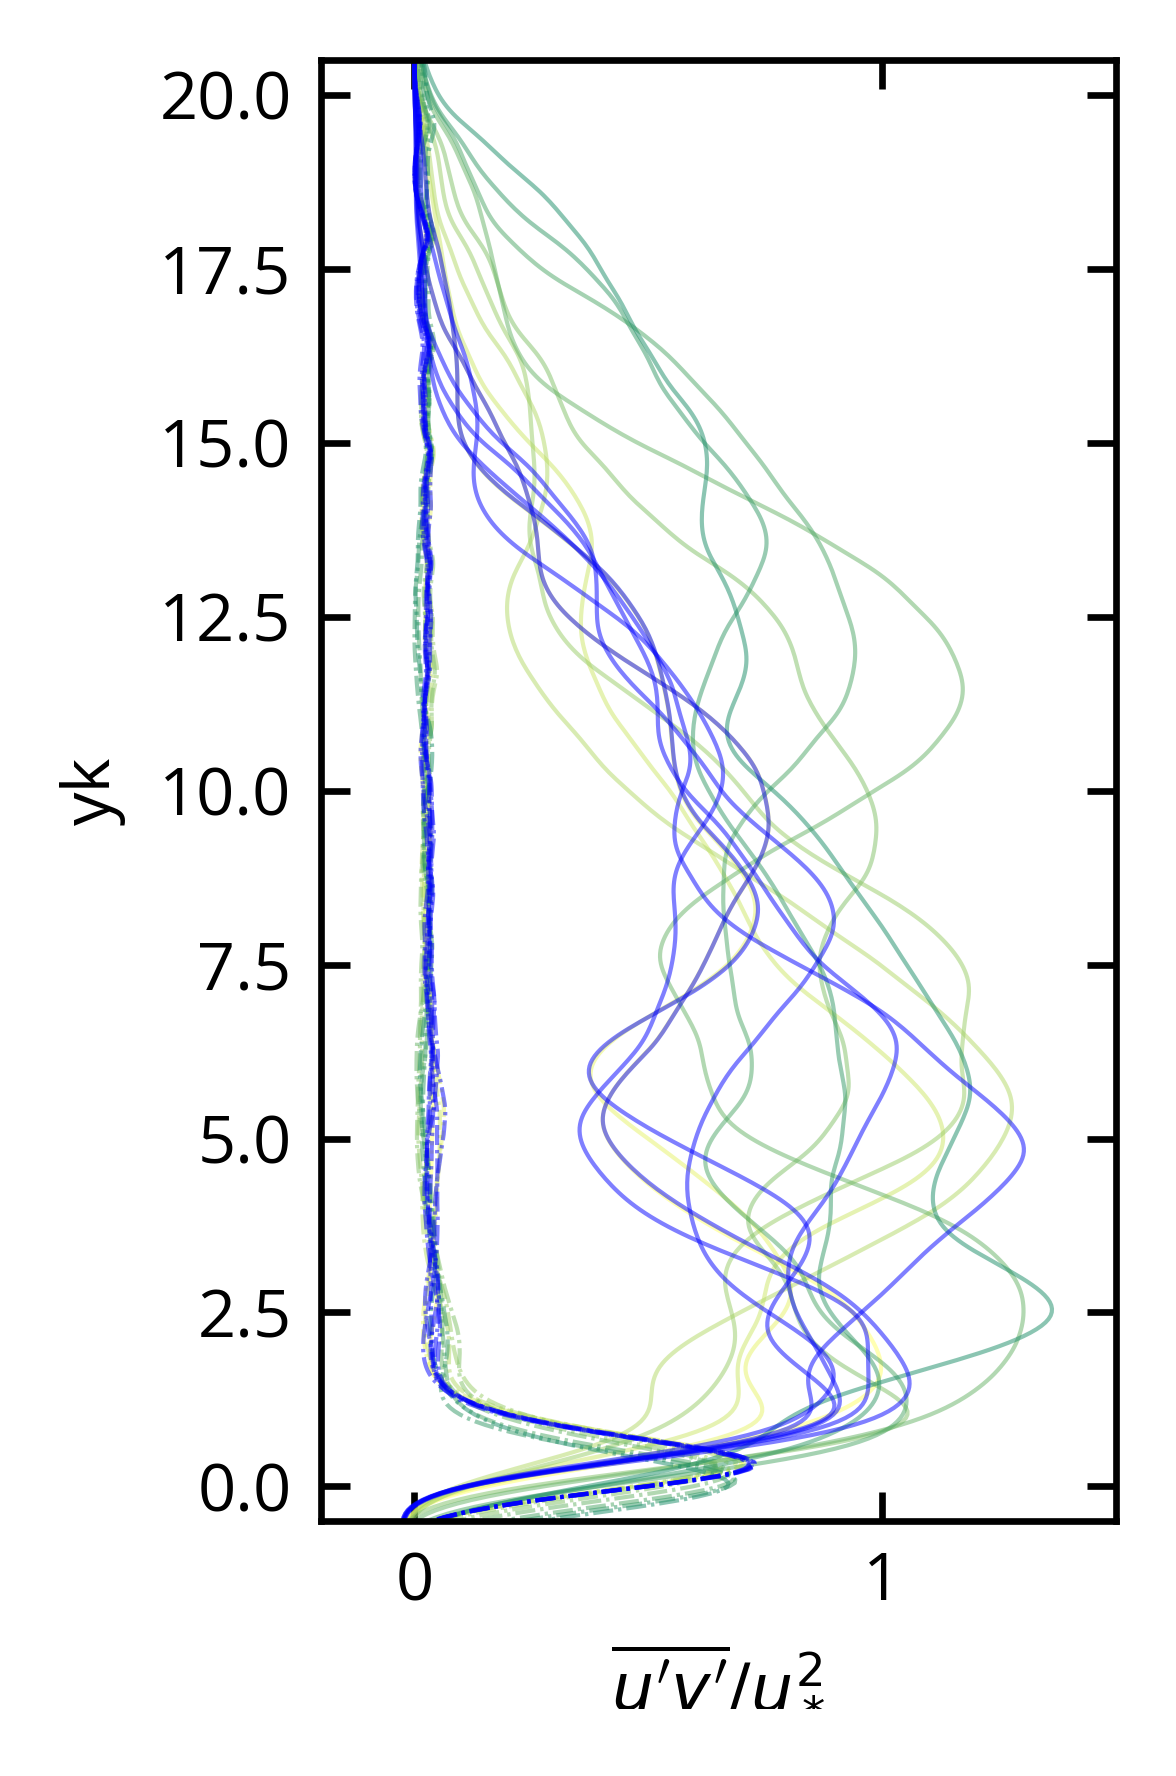

In [14]:
plt.figure(figsize=(2,3))
L0 = 2*np.pi; k = 4
nu_a = nu_a = 0.25*(2*np.pi-1)/360

re_stress = []
viscous_stress = []
N = 512
yarray = np.linspace(0,L0,N,endpoint=False)+L0/N/2
for (i,snapshot) in enumerate(snapshot_ensemble_720_moving_g1):
    # Reynolds stress
    re_stress_i = -np.average(snapshot.re_stress_2D, axis=0)
    re_stress_i = butter_lowpass_filter(re_stress_i)
    plt.plot(re_stress_i/0.25**2, (yarray-1)*k, color=plt.cm.get_cmap('summer')(1-i/10), alpha=0.5, lw=0.5)
    re_stress.append(re_stress_i)
    # Viscous stress
    ux_i = snapshot.ux_1D
    ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(yarray[1]-yarray[0])*nu_a
    plt.plot(viscous_stress_i/0.25**2, (yarray-1)*k, '-.', 
             color=plt.cm.get_cmap('summer')(1-i/10), alpha=0.5, lw=0.5)
    viscous_stress.append(viscous_stress_i)
# plt.plot(np.average(re_stress, axis=0)/0.25**2, (yarray-1)*k, c='blue', label=r'$\tau_t$')

re_stress = []
viscous_stress = []
N = 512
yarray = np.linspace(0,L0,N,endpoint=False)+L0/N/2
for (i,snapshot) in enumerate(snapshot_ensemble_720_pre):
    # Reynolds stress
    re_stress_i = -np.average(snapshot.re_stress_2D, axis=0)
    re_stress_i = butter_lowpass_filter(re_stress_i)
    plt.plot(re_stress_i/0.25**2, (yarray-1)*k, c='blue', alpha=0.5, lw=0.5)
    re_stress.append(re_stress_i)
    # Viscous stress
    ux_i = snapshot.ux_1D
    ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(yarray[1]-yarray[0])*nu_a
    plt.plot(viscous_stress_i/0.25**2, (yarray-1)*k, '-.', c='blue', alpha=0.5, lw=0.5)
    viscous_stress.append(viscous_stress_i)   
# plt.plot(np.average(re_stress, axis=0)/0.25**2, (yarray-1)*k, c='red', label=r'$\tau_t$')


# plt.plot(np.average(viscous_stress, axis=0)/0.25**2, (yarray-1)*k, '--', c='blue', label=r'$\tau_{\nu}$')
plt.xlabel('$\overline{u^{\prime} v^{\prime}}/u_*^2$'); plt.ylabel('yk')
plt.legend()
plt.ylim([-0.5,20.5])
plt.xlim([-0.2,1.5])

No handles with labels found to put in legend.


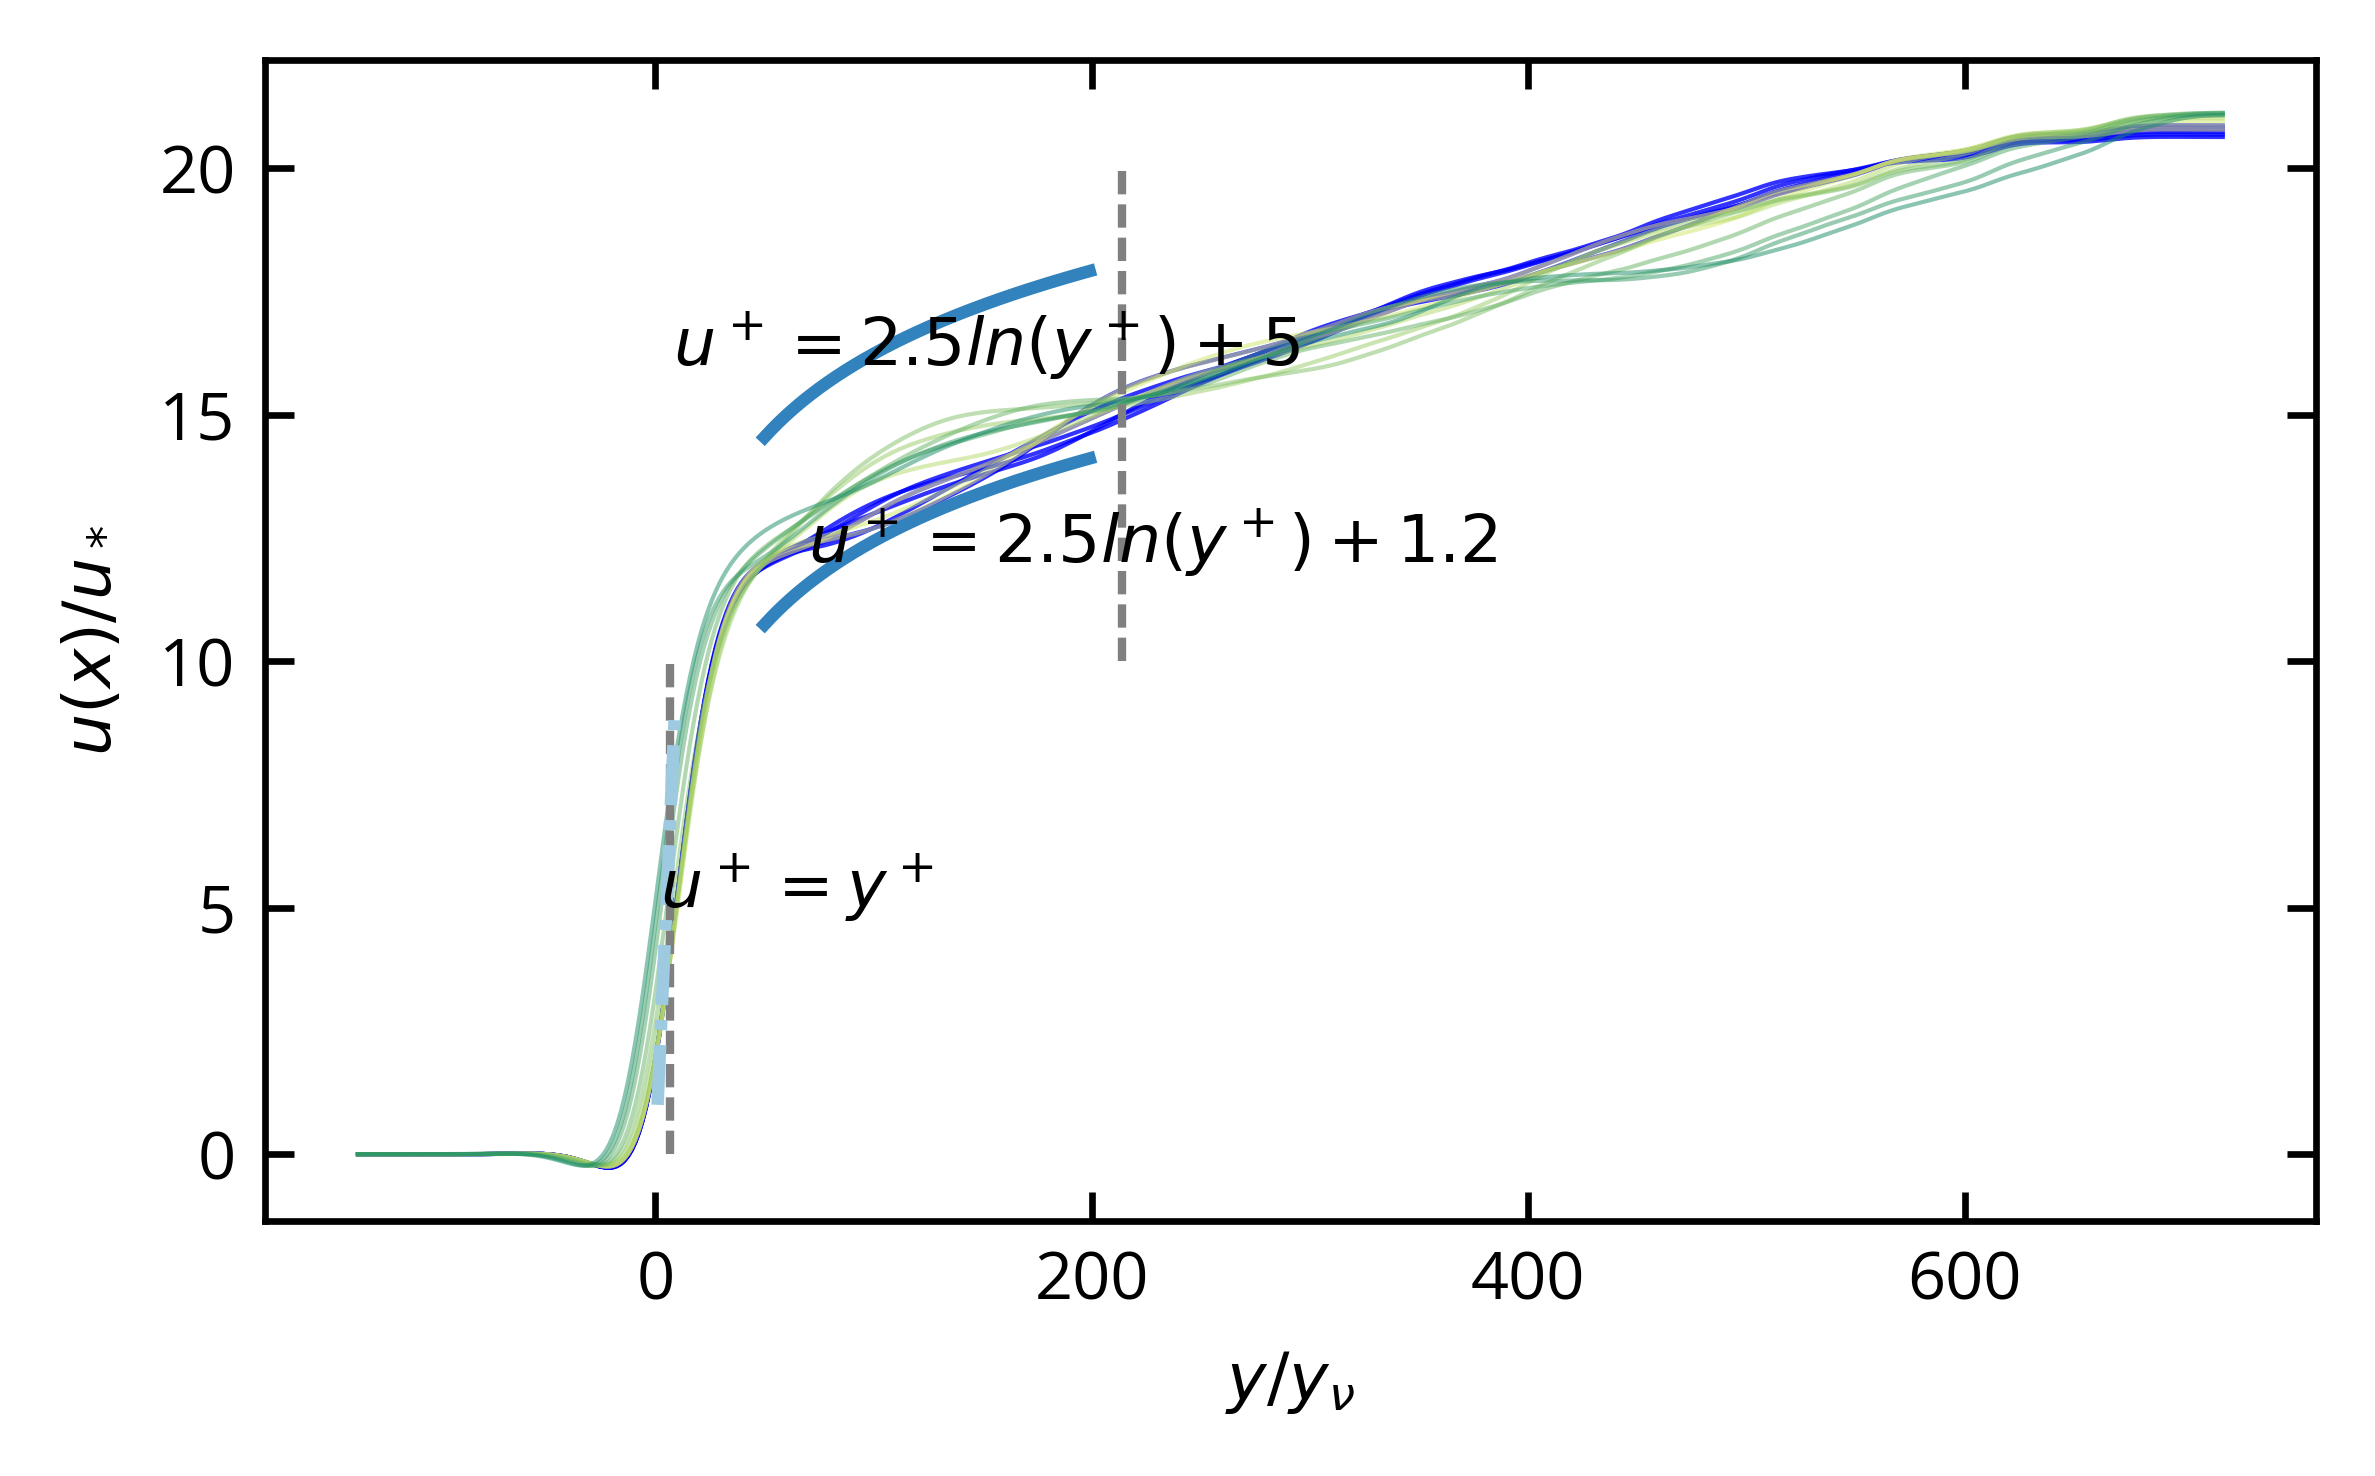

In [22]:
plt.figure(figsize=(4,2.5))
ux1 = []; ux2 = []; ux3 = []; ux4 = []
L0 = 2*np.pi
y_tau = (2*np.pi-1)/720
u_tau = 0.25

N = 512
yarray1 = np.linspace(0,L0,N,endpoint=False)+L0/2**N/2
for i in range(0,6):
    ux_i = snapshot_ensemble_720_pre[i].ux_1D
    ux_i = butter_lowpass_filter(ux_i)
    plt.plot((yarray1-1)/y_tau, ux_i/u_tau, c='blue', alpha=0.8, lw=0.5)
    ux1.append(ux_i)

N = 512
yarray2 = np.linspace(0,L0,N,endpoint=False)+L0/2**N/2
for i in range(0,10):
    ux_i = snapshot_ensemble_720_moving_g1[i].ux_1D
#     plt.plot(ux_i, yarray*k, '--', c='blue', alpha=0.5, lw=0.5)
    ux_i = butter_lowpass_filter(ux_i)
    plt.plot((yarray2-1)/y_tau, ux_i/u_tau, color=plt.cm.get_cmap('summer')(1-i/10),
             alpha=0.5, lw=0.5)
    ux2.append(ux_i)
    
# N = 512
# yarray2 = np.linspace(0,L0,N,endpoint=False)+L0/2**N/2
# for i in range(0,8):
#     ux_i = snapshot_ensemble_720_moving_g4[i].ux_1D
# #     plt.plot(ux_i, yarray*k, '--', c='blue', alpha=0.5, lw=0.5)
#     ux_i = butter_lowpass_filter(ux_i)
#     plt.plot((yarray2-1)/y_tau, ux_i/u_tau, '--', color=plt.cm.get_cmap('summer')(1-i/10),
#              alpha=0.5, lw=0.5)
#     ux3.append(ux_i)


# plt.plot((yarray1-1)/y_tau, np.average(ux1,axis=0)/u_tau, c='blue', label = 'stationary wave')
# plt.plot((yarray2-1)/y_tau, np.average(ux2,axis=0)/u_tau, c='darkviolet', label = '1T')
# plt.plot((yarray2-1)/y_tau, np.average(ux3,axis=0)/u_tau, c='magenta', label = '4T')
# plt.plot((yarray2-1)/y_tau, np.average(ux4,axis=0)/u_tau, c='red', label = '6T')
plt.plot(np.ones(100)*(0.2/4)/y_tau, np.linspace(0,10,100), '--', c='gray',lw=1)
plt.plot(np.ones(100)*(2*np.pi/4)/y_tau, np.linspace(10,20,100), '--', c='gray',lw=1)
y = np.arange(50,200)
plt.plot(y, 1/0.41*np.log(y)+5, color=plt.get_cmap('tab20c')(0))
plt.text(8,16, r'$u^+=2.5ln(y^+)+5$')
# plt.plot(y, 1/0.41*np.log(y)+1.5, color=plt.get_cmap('tab20c')(0))
# plt.text(70,10, r'$u^+=2.5ln(y^+)+1.5$')
plt.plot(y, 1/0.41*np.log(y)+1.2, color=plt.get_cmap('tab20c')(0))
plt.text(70,12, r'$u^+=2.5ln(y^+)+1.2$')
y = np.arange(1,10)
plt.plot(y, y, '-.', color=plt.get_cmap('tab20c')(2))
plt.text(2,5, r'$u^+=y^+$')
# plt.xscale('log')
plt.ylabel(r'$u(x)/u_*$'); plt.xlabel(r'$y/y_{\nu}$'); plt.legend(loc='upper left')

In [26]:
np.average(snapshot.eta_1D)

0.9202134560012818

Text(10, 22, '$v/u_*$')

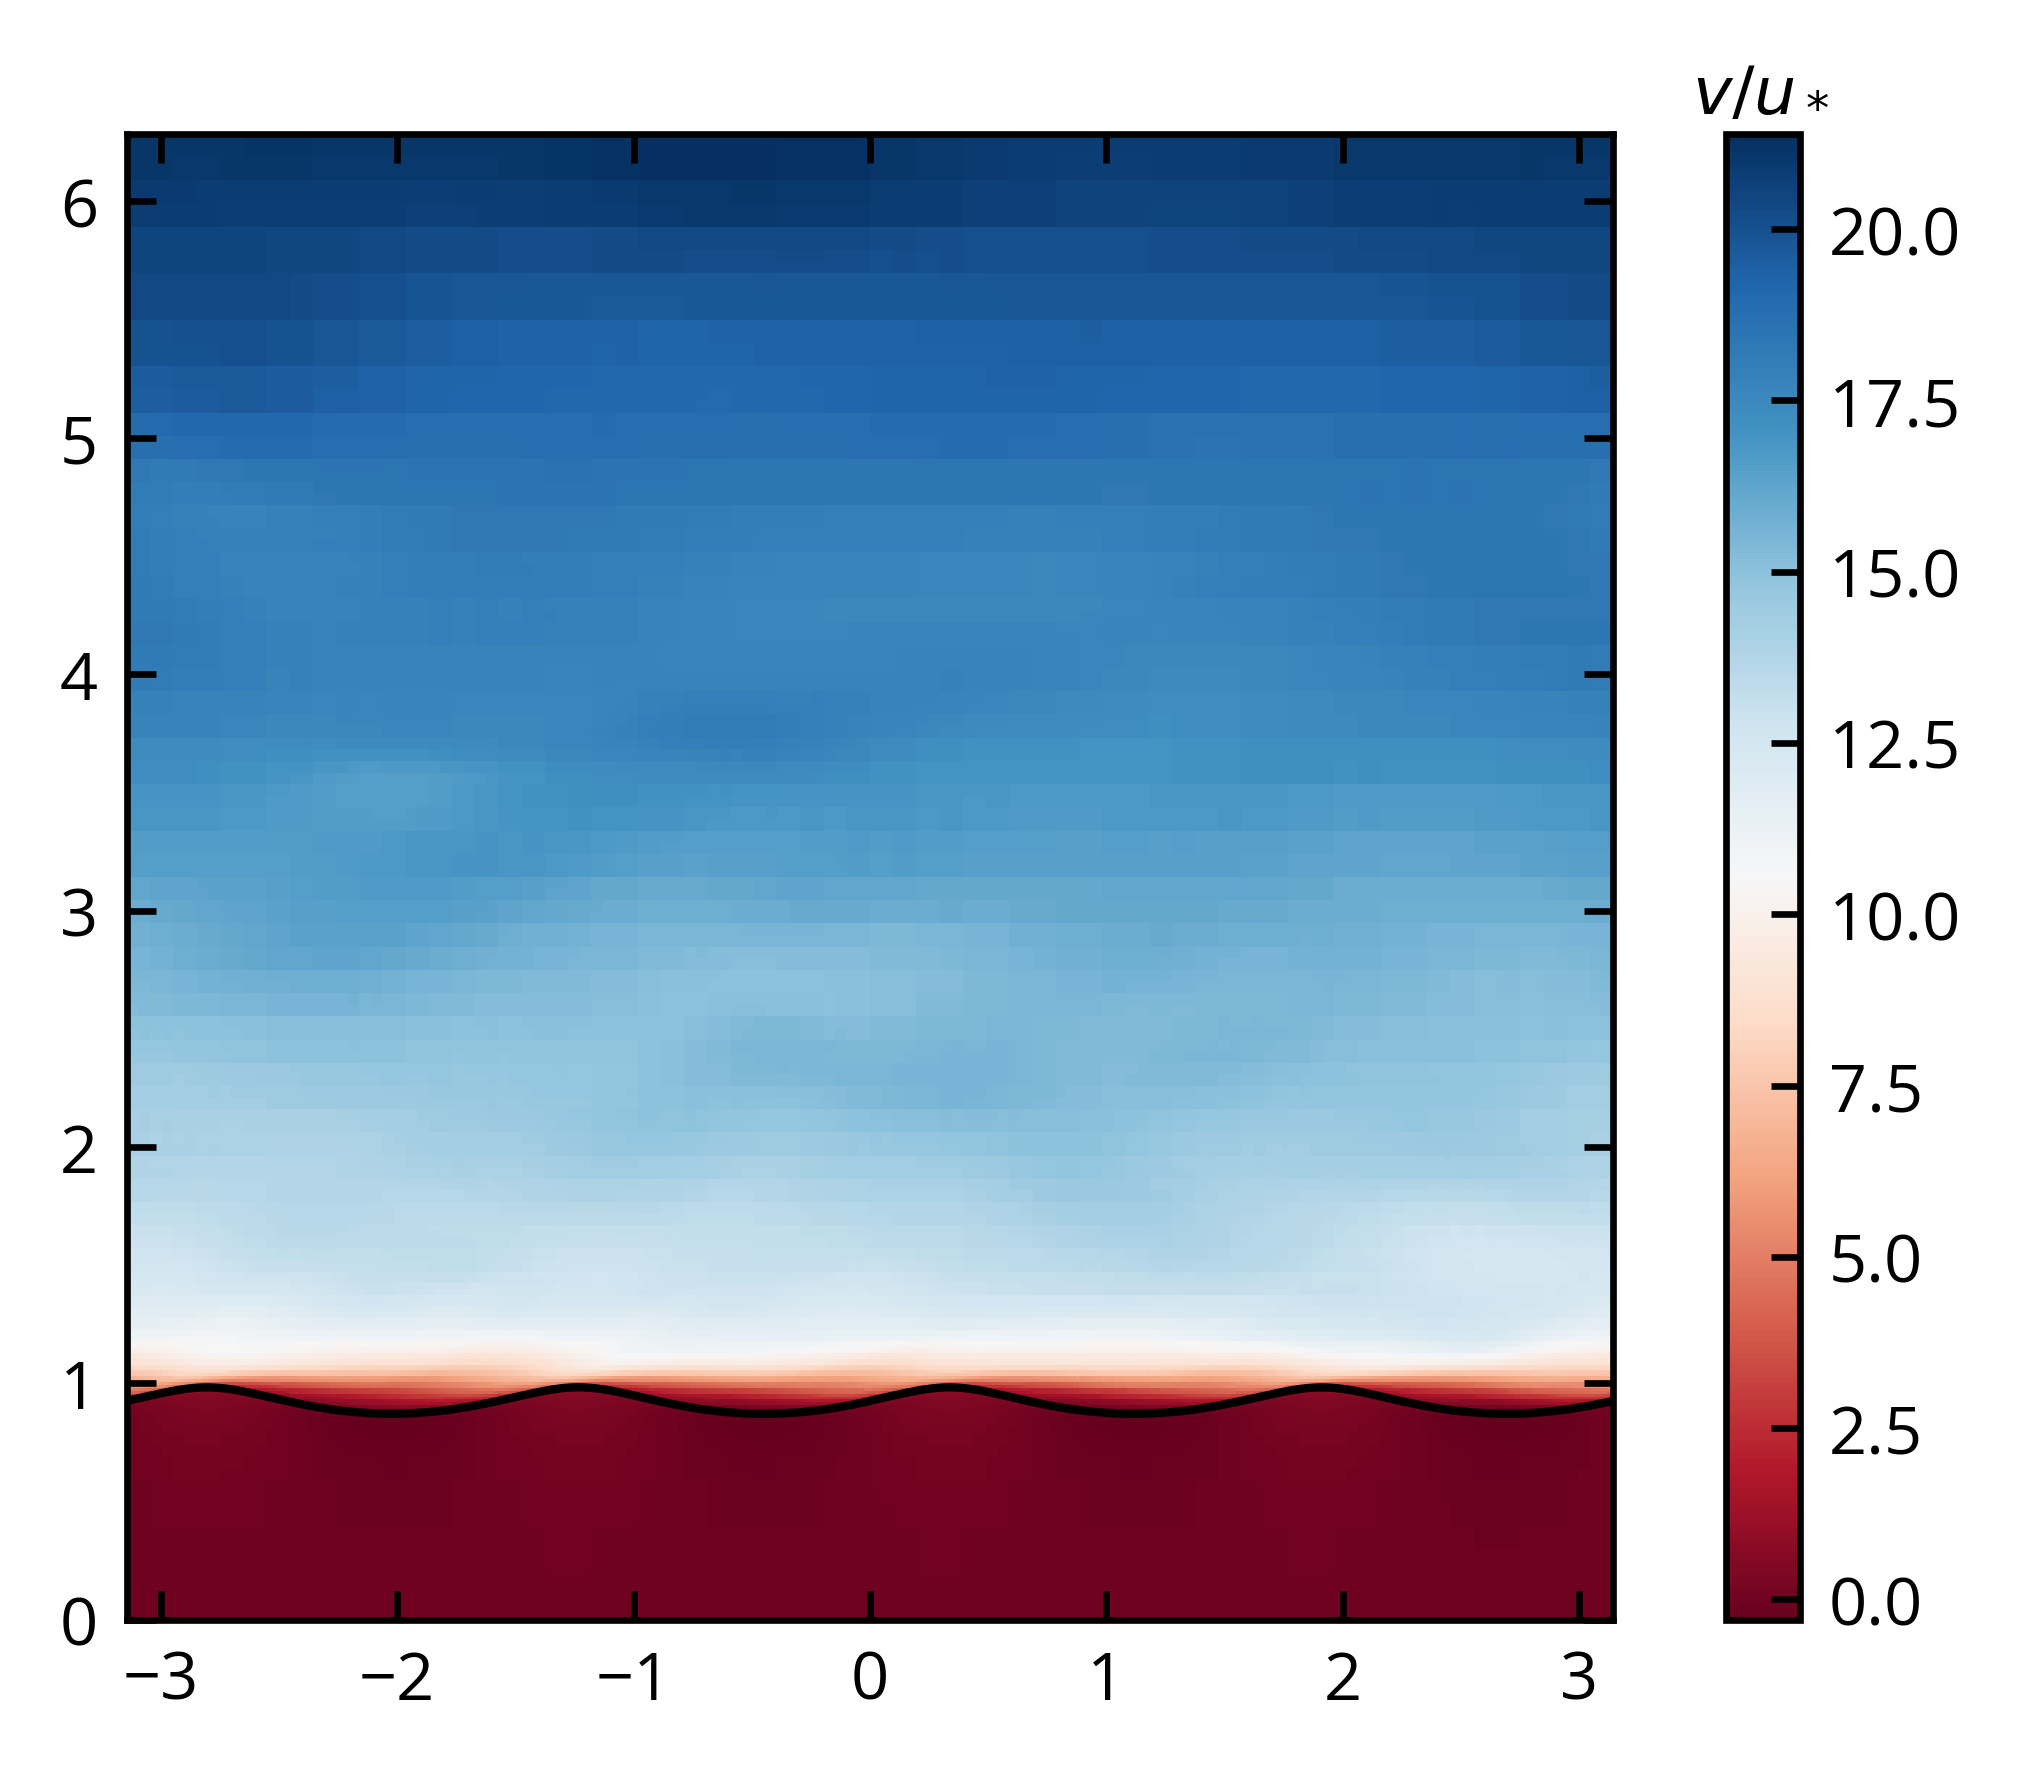

In [35]:
snapshot = snapshot_ensemble_720_moving_g1[-1]
plt.figure(figsize=[4,3])
plt.imshow(np.rot90(snapshot.ux_2D/0.25), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi])
L0 = 2*np.pi; NGRID = 512
xarray = np.linspace(-L0/2,L0/2,NGRID)
plt.plot(xarray, snapshot.eta_1D,'k',lw=1)
cbar = plt.colorbar()
cbar.ax.text(10, 22, r'$v/u_*$', ha='center', va='center')

In [7]:
for snapshot in snapshot_ensemble_720_moving_16:
    snapshot.eta_1D_filtered = butter_lowpass_filter(snapshot.eta_1D-np.average(snapshot.eta_1D))
    analytic_signal = hilbert(snapshot.eta_1D_filtered)
    snapshot.phase = np.angle(analytic_signal)
    # Shift the velocity field along x axis so that phase starts at 0
    snapshot.idx = (np.abs(snapshot.phase - 0)).argmin()

/home/jiarong/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(array([ 35, 163, 290, 418]),)
(array([ 99, 227, 354, 482]),)


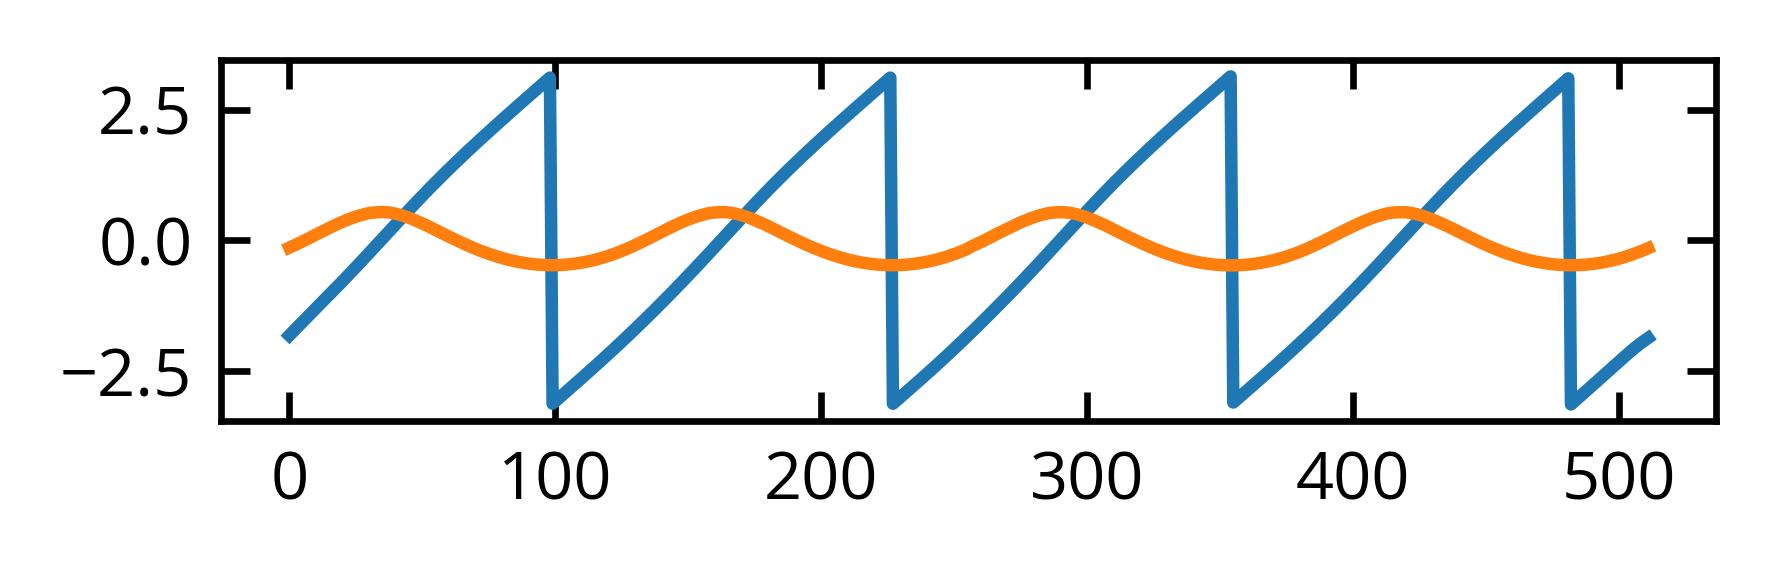

In [24]:
plt.figure(figsize=[3,1])
snapshot = snapshot_ensemble_720_moving_16[3]
plt.plot(snapshot.phase)
plt.plot((snapshot.eta_1D-1)*10)
from scipy.signal import argrelextrema
# determine the indices of the local maxima
max_ind = argrelextrema(snapshot.eta_1D-1, np.greater)
min_ind = argrelextrema(-(snapshot.eta_1D-1), np.greater)
print(max_ind)
print(min_ind)

In [25]:
crest = np.average(snapshot.ux_2D[max_ind],axis=0)
trough = np.average(snapshot.ux_2D[min_ind],axis=0)

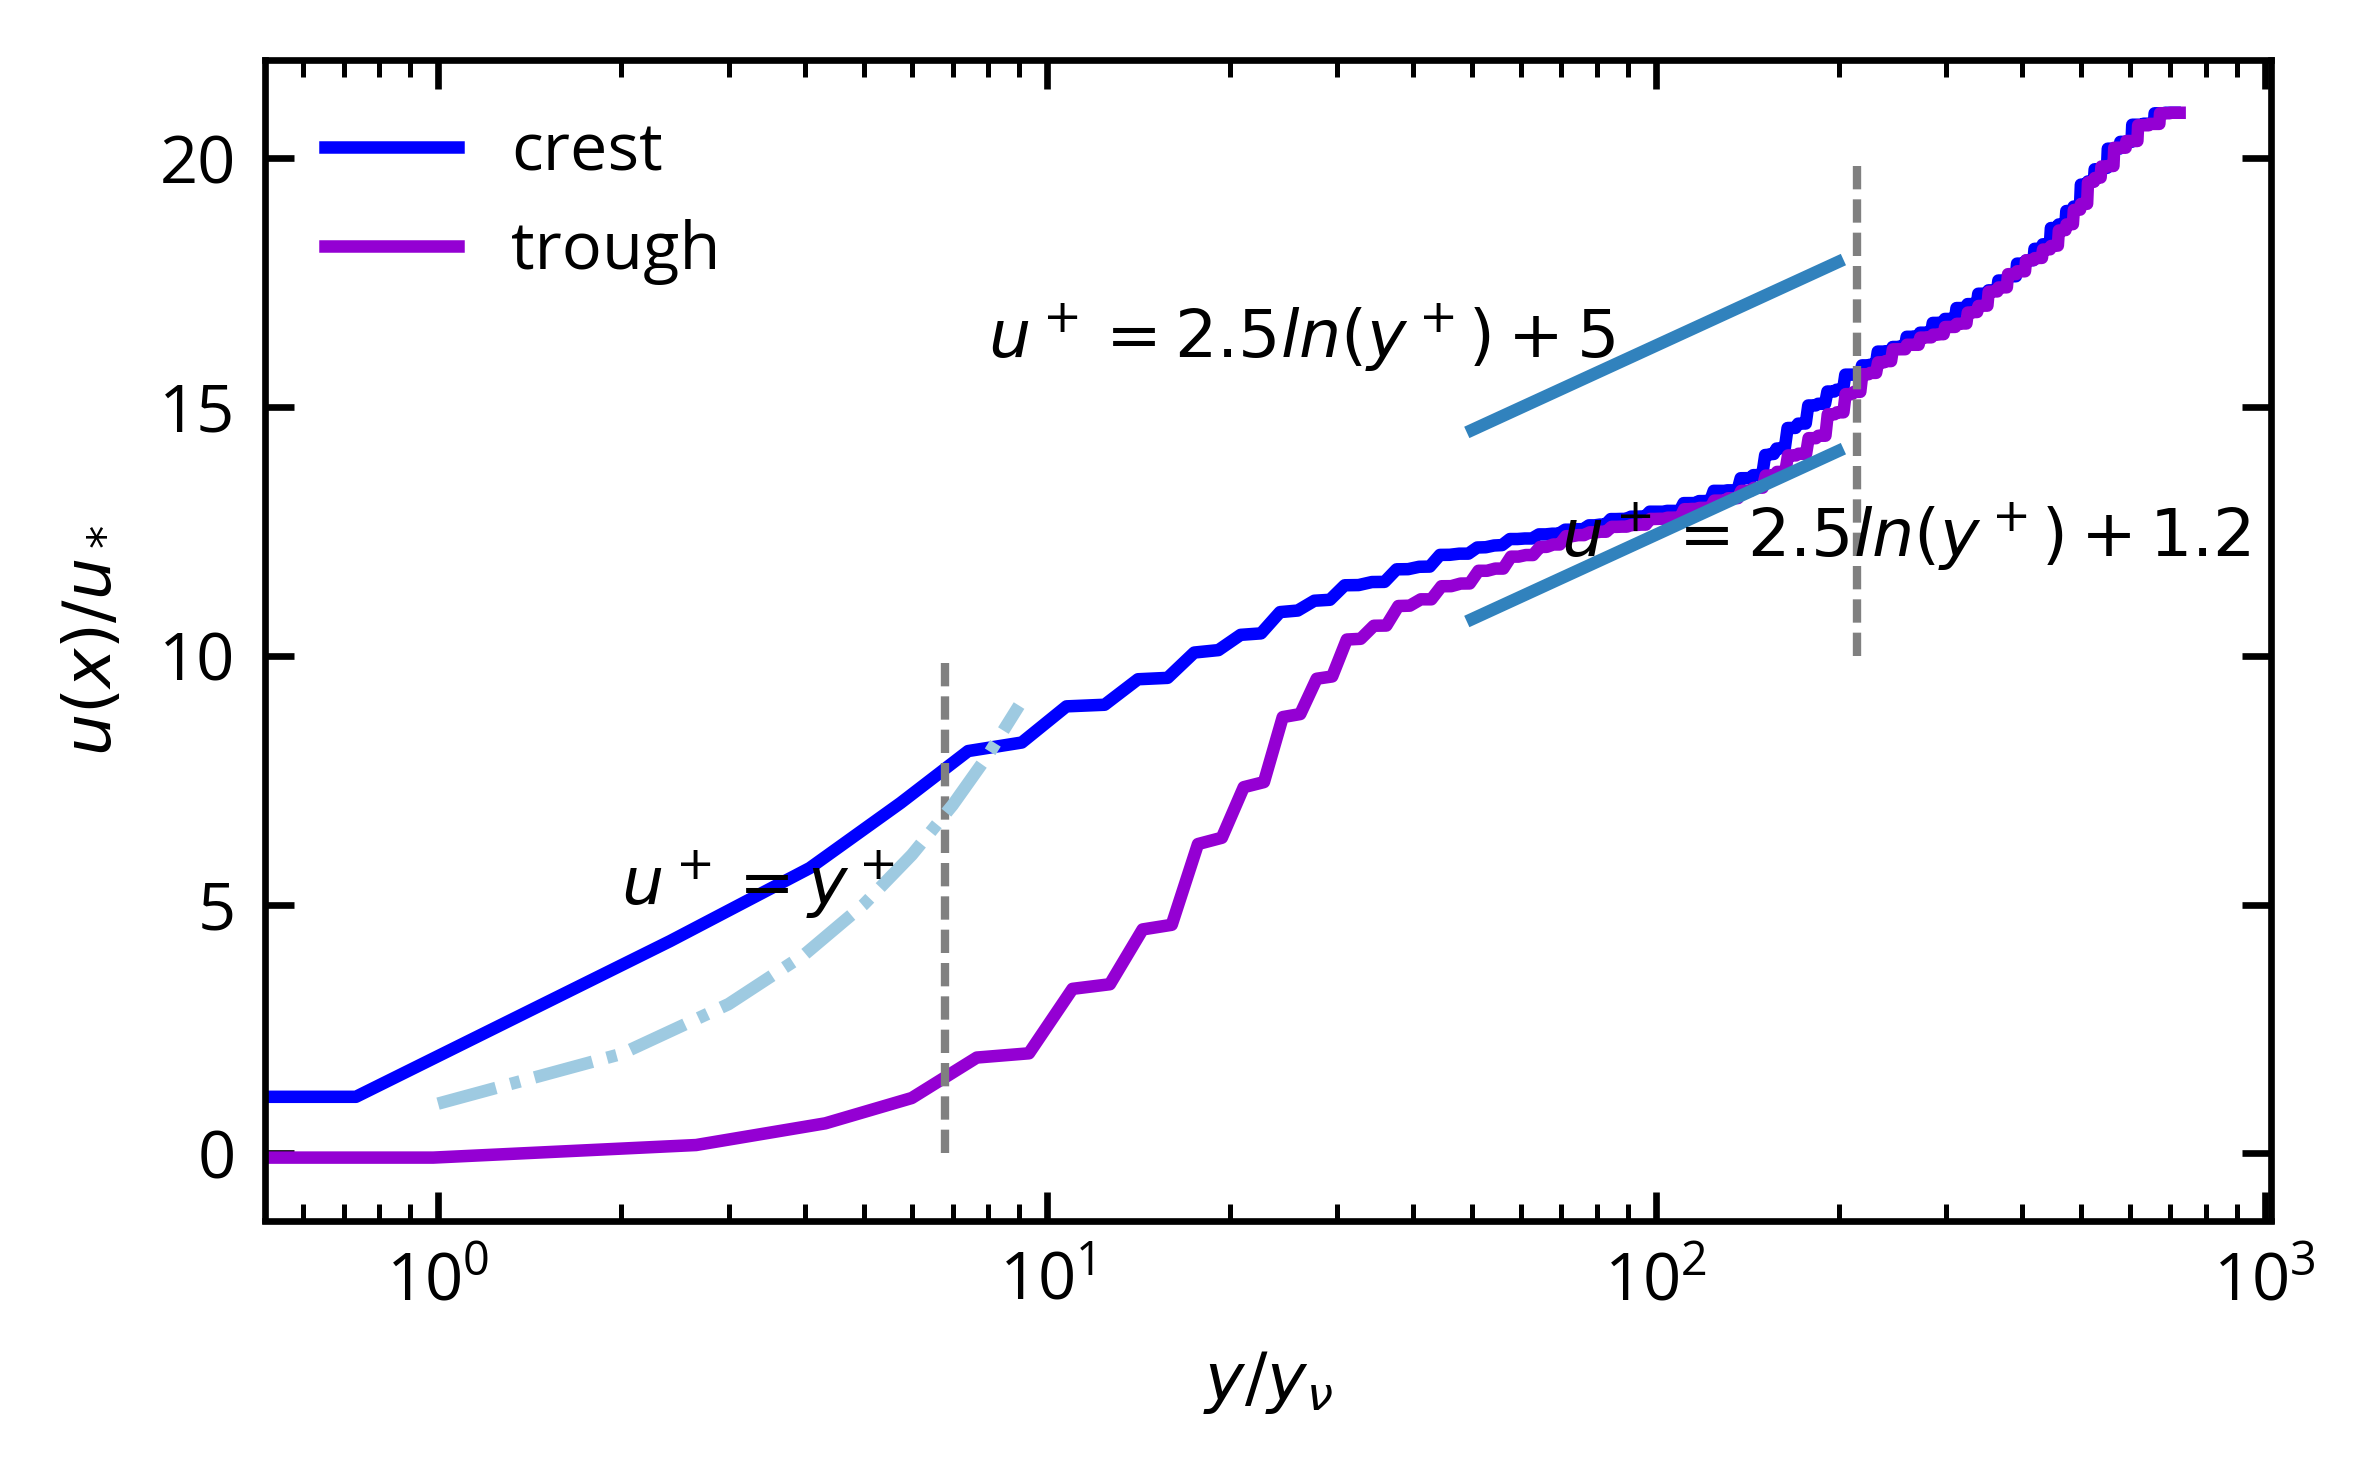

In [29]:
plt.figure(figsize=(4,2.5))
ux1 = []; ux2 = []; ux3 = []; ux4 = []
L0 = 2*np.pi
y_tau = (2*np.pi-1)/720
u_tau = 0.25

N = 512
yarray1 = np.linspace(0,L0,N,endpoint=False)+L0/2**N/2
plt.plot((yarray1-1-0.2/4)/y_tau, crest/u_tau, c='blue', label='crest')
plt.plot((yarray1-1+0.2/4)/y_tau, trough/u_tau, c='darkviolet', label='trough')


# N = 512
# yarray2 = np.linspace(0,L0,N,endpoint=False)+L0/2**N/2
# for i in range(2,4):
#     ux_i = snapshot_ensemble_720_moving_16[i].ux_1D
# #     plt.plot(ux_i, yarray*k, '--', c='blue', alpha=0.5, lw=0.5)
#     ux_i = butter_lowpass_filter(ux_i)
#     plt.plot((yarray2-1)/y_tau, ux_i/u_tau, c='darkviolet',
#              alpha=0.5, lw=0.5)
#     ux2.append(ux_i)
    
# for i in range(10,15):
#     ux_i = snapshot_ensemble[i].ux_1D
# #     plt.plot(ux_i, yarray*k, '--', c='blue', alpha=0.5, lw=0.5)
#     ux_i = butter_lowpass_filter(ux_i)
#     plt.plot((yarray2-1)/y_tau, ux_i/u_tau, c='magenta', alpha=0.5, lw=0.5)
#     ux3.append(ux_i)
    
# for i in range(16,21):
#     ux_i = snapshot_ensemble[i].ux_1D
# #     plt.plot(ux_i, yarray*k, '--', c='blue', alpha=0.5, lw=0.5)
#     ux_i = butter_lowpass_filter(ux_i)
#     plt.plot((yarray2-1)/y_tau, ux_i/u_tau, c='red', alpha=0.5, lw=0.5)
#     ux4.append(ux_i)

# plt.plot((yarray1-1)/y_tau, np.average(ux1,axis=0)/u_tau, c='blue', label = 'stationary wave')
# plt.plot((yarray2-1)/y_tau, np.average(ux2,axis=0)/u_tau, c='darkviolet', label = '1T')
# plt.plot((yarray2-1)/y_tau, np.average(ux3,axis=0)/u_tau, c='magenta', label = '4T')
# plt.plot((yarray2-1)/y_tau, np.average(ux4,axis=0)/u_tau, c='red', label = '6T')
plt.plot(np.ones(100)*(0.2/4)/y_tau, np.linspace(0,10,100), '--', c='gray',lw=1)
plt.plot(np.ones(100)*(2*np.pi/4)/y_tau, np.linspace(10,20,100), '--', c='gray',lw=1)
y = np.arange(50,200)
plt.plot(y, 1/0.41*np.log(y)+5, color=plt.get_cmap('tab20c')(0))
plt.text(8,16, r'$u^+=2.5ln(y^+)+5$')
# plt.plot(y, 1/0.41*np.log(y)+1.5, color=plt.get_cmap('tab20c')(0))
# plt.text(70,10, r'$u^+=2.5ln(y^+)+1.5$')
plt.plot(y, 1/0.41*np.log(y)+1.2, color=plt.get_cmap('tab20c')(0))
plt.text(70,12, r'$u^+=2.5ln(y^+)+1.2$')
y = np.arange(1,10)
plt.plot(y, y, '-.', color=plt.get_cmap('tab20c')(2))
plt.text(2,5, r'$u^+=y^+$')
plt.xscale('log')
plt.ylabel(r'$u(x)/u_*$'); plt.xlabel(r'$y/y_{\nu}$'); plt.legend(loc='upper left')

In [ ]:
dirname = '/home/jiarong/research/projects/turbulence/curved_fixREtau_precursor_REtau360_ak0.2_LEVEL10_emax0.3/'
# snapshot_ensemble_360_moving_MU32 = []
for i in tqdm(range(0,4)):
    t = 62 + i
    snapshot = Snapshot(t, working_dir=dirname, NSLICE=256, NGRID=512, L0=2*np.pi)
    snapshot_ensemble_360_10.append(snapshot)

In [159]:
from scipy.interpolate import interp1d
def water_profile(u_water, eta, L0):
    '''
        u_water: a 2D velocity slice, axis0 in x, axis1 in y (denote here as z)
        eta: a 1D velocity slice;
        L0: domain size.
    '''
    u_water_1D_nointerp = np.average(u_water, axis=0)
    u_water_interp = np.zeros(u_water.shape)
    for i in range(u_water.shape[0]):
        zmax = L0/2.; zmin = - L0/2.
        zgrid = np.linspace(zmin, zmax, 512)
        z = np.linspace(-L0/2,L0/2,512) - eta[i]
        f = interp1d(zgrid, u_water[i,:], fill_value='extrapolate')
        ugrid = f(z)
        u_water_interp[i] = ugrid
    u_water_1D = np.average(u_water_interp, axis=0)
    return u_water, u_water_interp, u_water_1D, zgrid

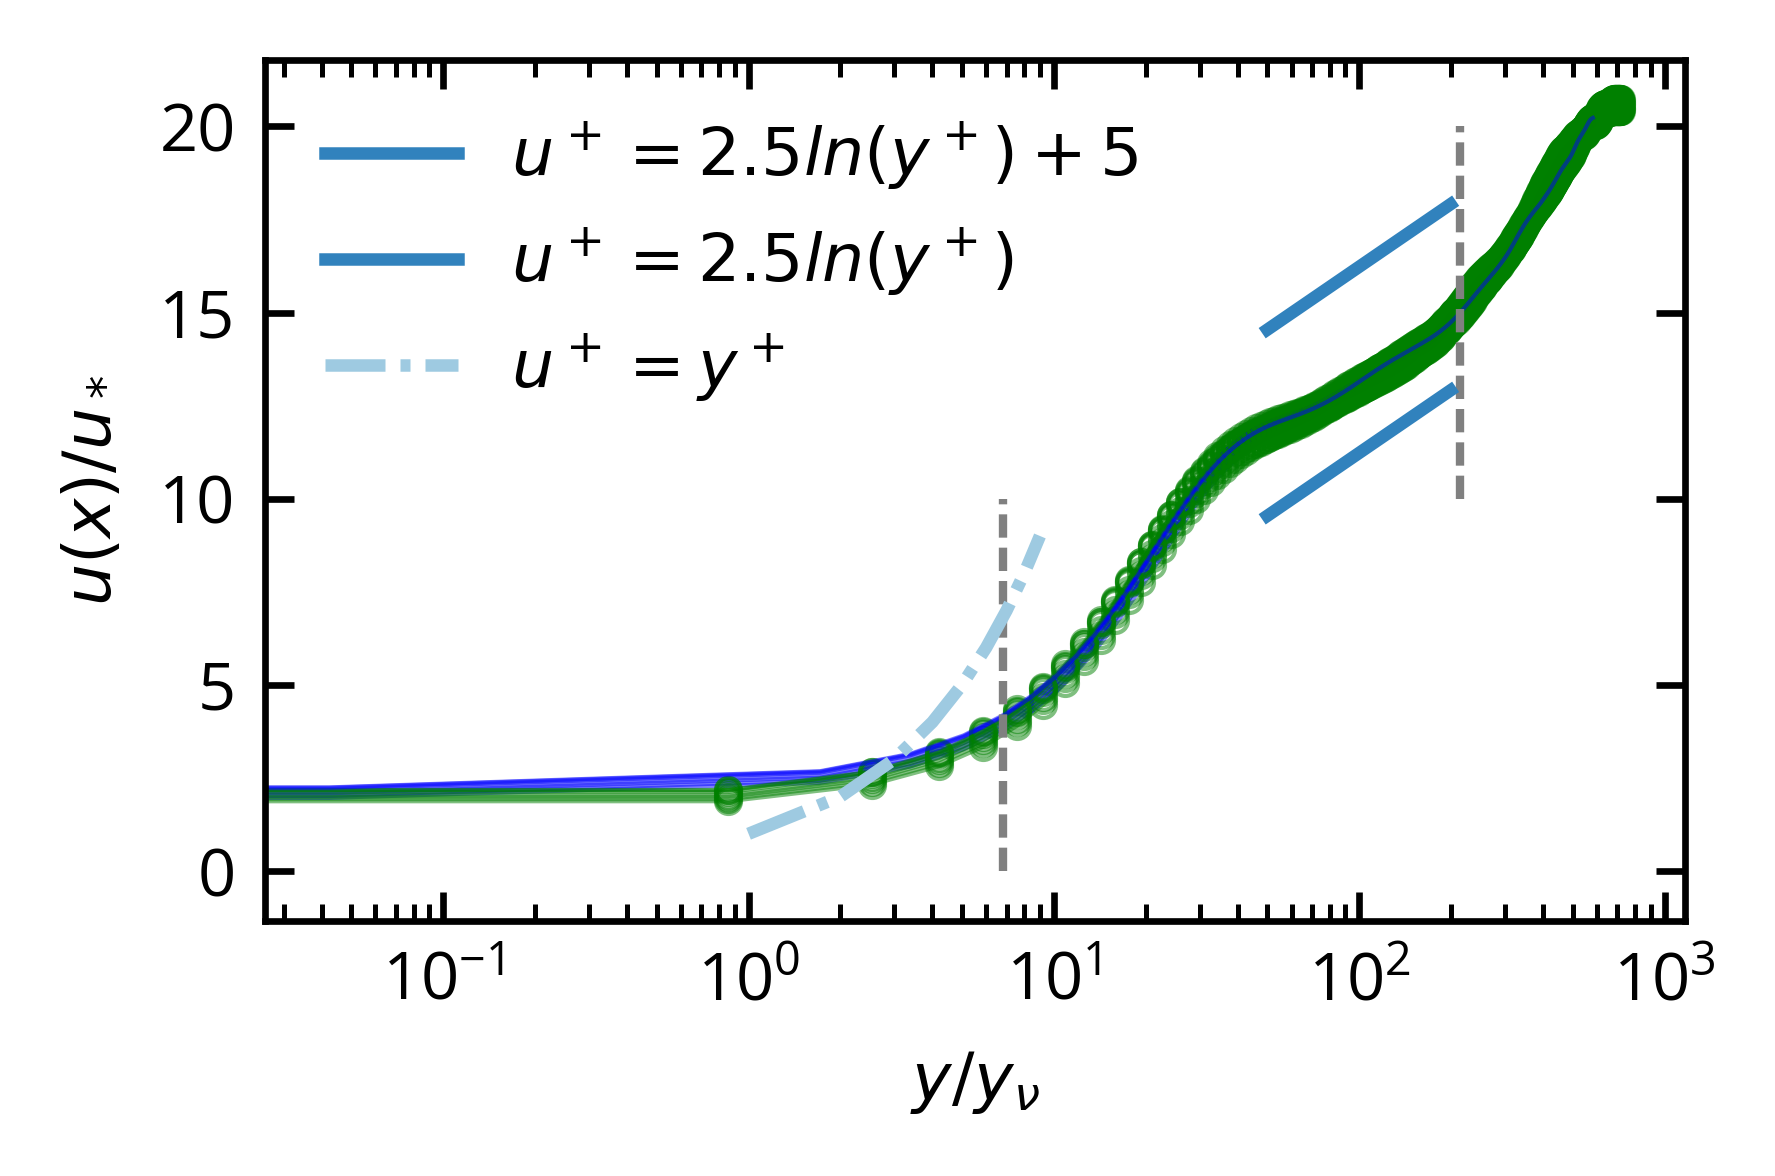

In [162]:
plt.figure(figsize=(3,2))
ux = []; ux_interp = []
y_tau = (2*np.pi-1)/720
u_tau = 0.25

for snapshot in snapshot_ensemble[0:7]:
    
    # Not interpolated
    ux_i = snapshot.ux_1D
    ux_i = butter_lowpass_filter(ux_i)
    plt.plot((yarray-1)/y_tau, ux_i/u_tau, c='green', alpha=0.5, lw=0.5, marker = 'o', mfc='none', markeredgewidth=0.5, markersize=3)
    ux.append(ux_i)
    
    # Coordinate transformed     
    u_water, u_water_interp, u_water_1D, zgrid = water_profile(snapshot.ux_2D, snapshot.eta_1D, L0=np.pi*2) 
    u_water_1D = butter_lowpass_filter(u_water_1D)
#     plt.plot((yarray-1)/y_tau, u_water_1D/u_tau, c='blue', alpha=0.5, lw=0.5, marker = '^', mfc='none', markeredgewidth=0.5, markersize=3)
    plt.plot((yarray-1-1)/y_tau, u_water_1D/u_tau, c='blue', alpha=0.5, lw=0.5)
    ux_interp.append(u_water_1D)

# plt.plot((yarray-1)/y_tau, np.average(ux,axis=0)/u_tau, '.', c='green')
# plt.plot((yarray-1)/y_tau, np.average(ux_interp,axis=0)/u_tau, '.', c='blue')

plt.plot(np.ones(100)*(0.2/4)/y_tau, np.linspace(0,10,100), '--', c='gray',lw=1)
plt.plot(np.ones(100)*(2*np.pi/4)/y_tau, np.linspace(10,20,100), '--', c='gray',lw=1)
y = np.arange(50,200)
plt.plot(y, 1/0.41*np.log(y)+5, label=r'$u^+=2.5ln(y^+)+5$', color=plt.get_cmap('tab20c')(0))
plt.plot(y, 1/0.41*np.log(y), label=r'$u^+=2.5ln(y^+)$', color=plt.get_cmap('tab20c')(0))
y = np.arange(1,10)
plt.plot(y, y, '-.', label=r'$u^+=y^+$', color=plt.get_cmap('tab20c')(2))
plt.xscale('log'); plt.ylabel(r'$u(x)/u_*$'); plt.xlabel(r'$y/y_{\nu}$'); plt.legend(loc='upper left')

In [189]:
from scipy.interpolate import interp1d
def water_profile(u_water, eta, L0):
    '''
        u_water: a 2D velocity slice, axis0 in x, axis1 in y (denote here as z)
        eta: a 1D velocity slice;
        L0: domain size.
    '''
    u_water_1D_nointerp = np.average(u_water, axis=0)
    
    # Interpolate by simply taking difference
    u_water_interp = np.zeros(u_water.shape)
    for i in range(u_water.shape[0]):
        zmax = L0; zmin = 0.
        zgrid = np.linspace(zmin, zmax, 512, endpoint=False) + (zmax-zmin)/512/2
        z1 = np.linspace(-L0/2,L0/2,512) + eta[i]
        f = interp1d(zgrid, u_water[i,:], fill_value='extrapolate', kind='quadratic')
        ugrid = f(zgrid)
        u_water_interp[i] = ugrid
    u_water_interp_1D = np.average(u_water_interp, axis=0)
    phase_aver_interp = u_water_interp - np.tile(u_water_interp_1D, (NGRID, 1))
    
    # Interpolate back to Cartisan coord to plot
    phase_aver_cart = np.zeros(phase_aver_interp.shape)
    for i in range(u_water.shape[0]):
        zmax = L0/2.; zmin = - L0/2.
        zgrid = np.linspace(zmin, zmax, 512)
        z = np.linspace(-L0/2,L0/2,512) + eta[i]
        g = interp1d(z, phase_aver_interp[i,:], fill_value='extrapolate',  kind='quadratic')
        ugrid = g(zgrid)
        phase_aver_cart[i] = ugrid
    return u_water, u_water_interp, phase_aver_cart, phase_aver_interp, u_water_interp_1D

In [1]:
plt.figure(figsize=[4,3])
plt.imshow(np.rot90(snapshot_ensemble[5].ux_2D)/0.25, cmap='RdBu', 
           extent=[-np.pi,np.pi,0,2*np.pi])
xarray = np.linspace(-L0/2,L0/2,256)
i = 2
plt.plot(xarray, snapshot_ensemble[i].eta_1D,'k',lw=1)

NameError: name 'plt' is not defined

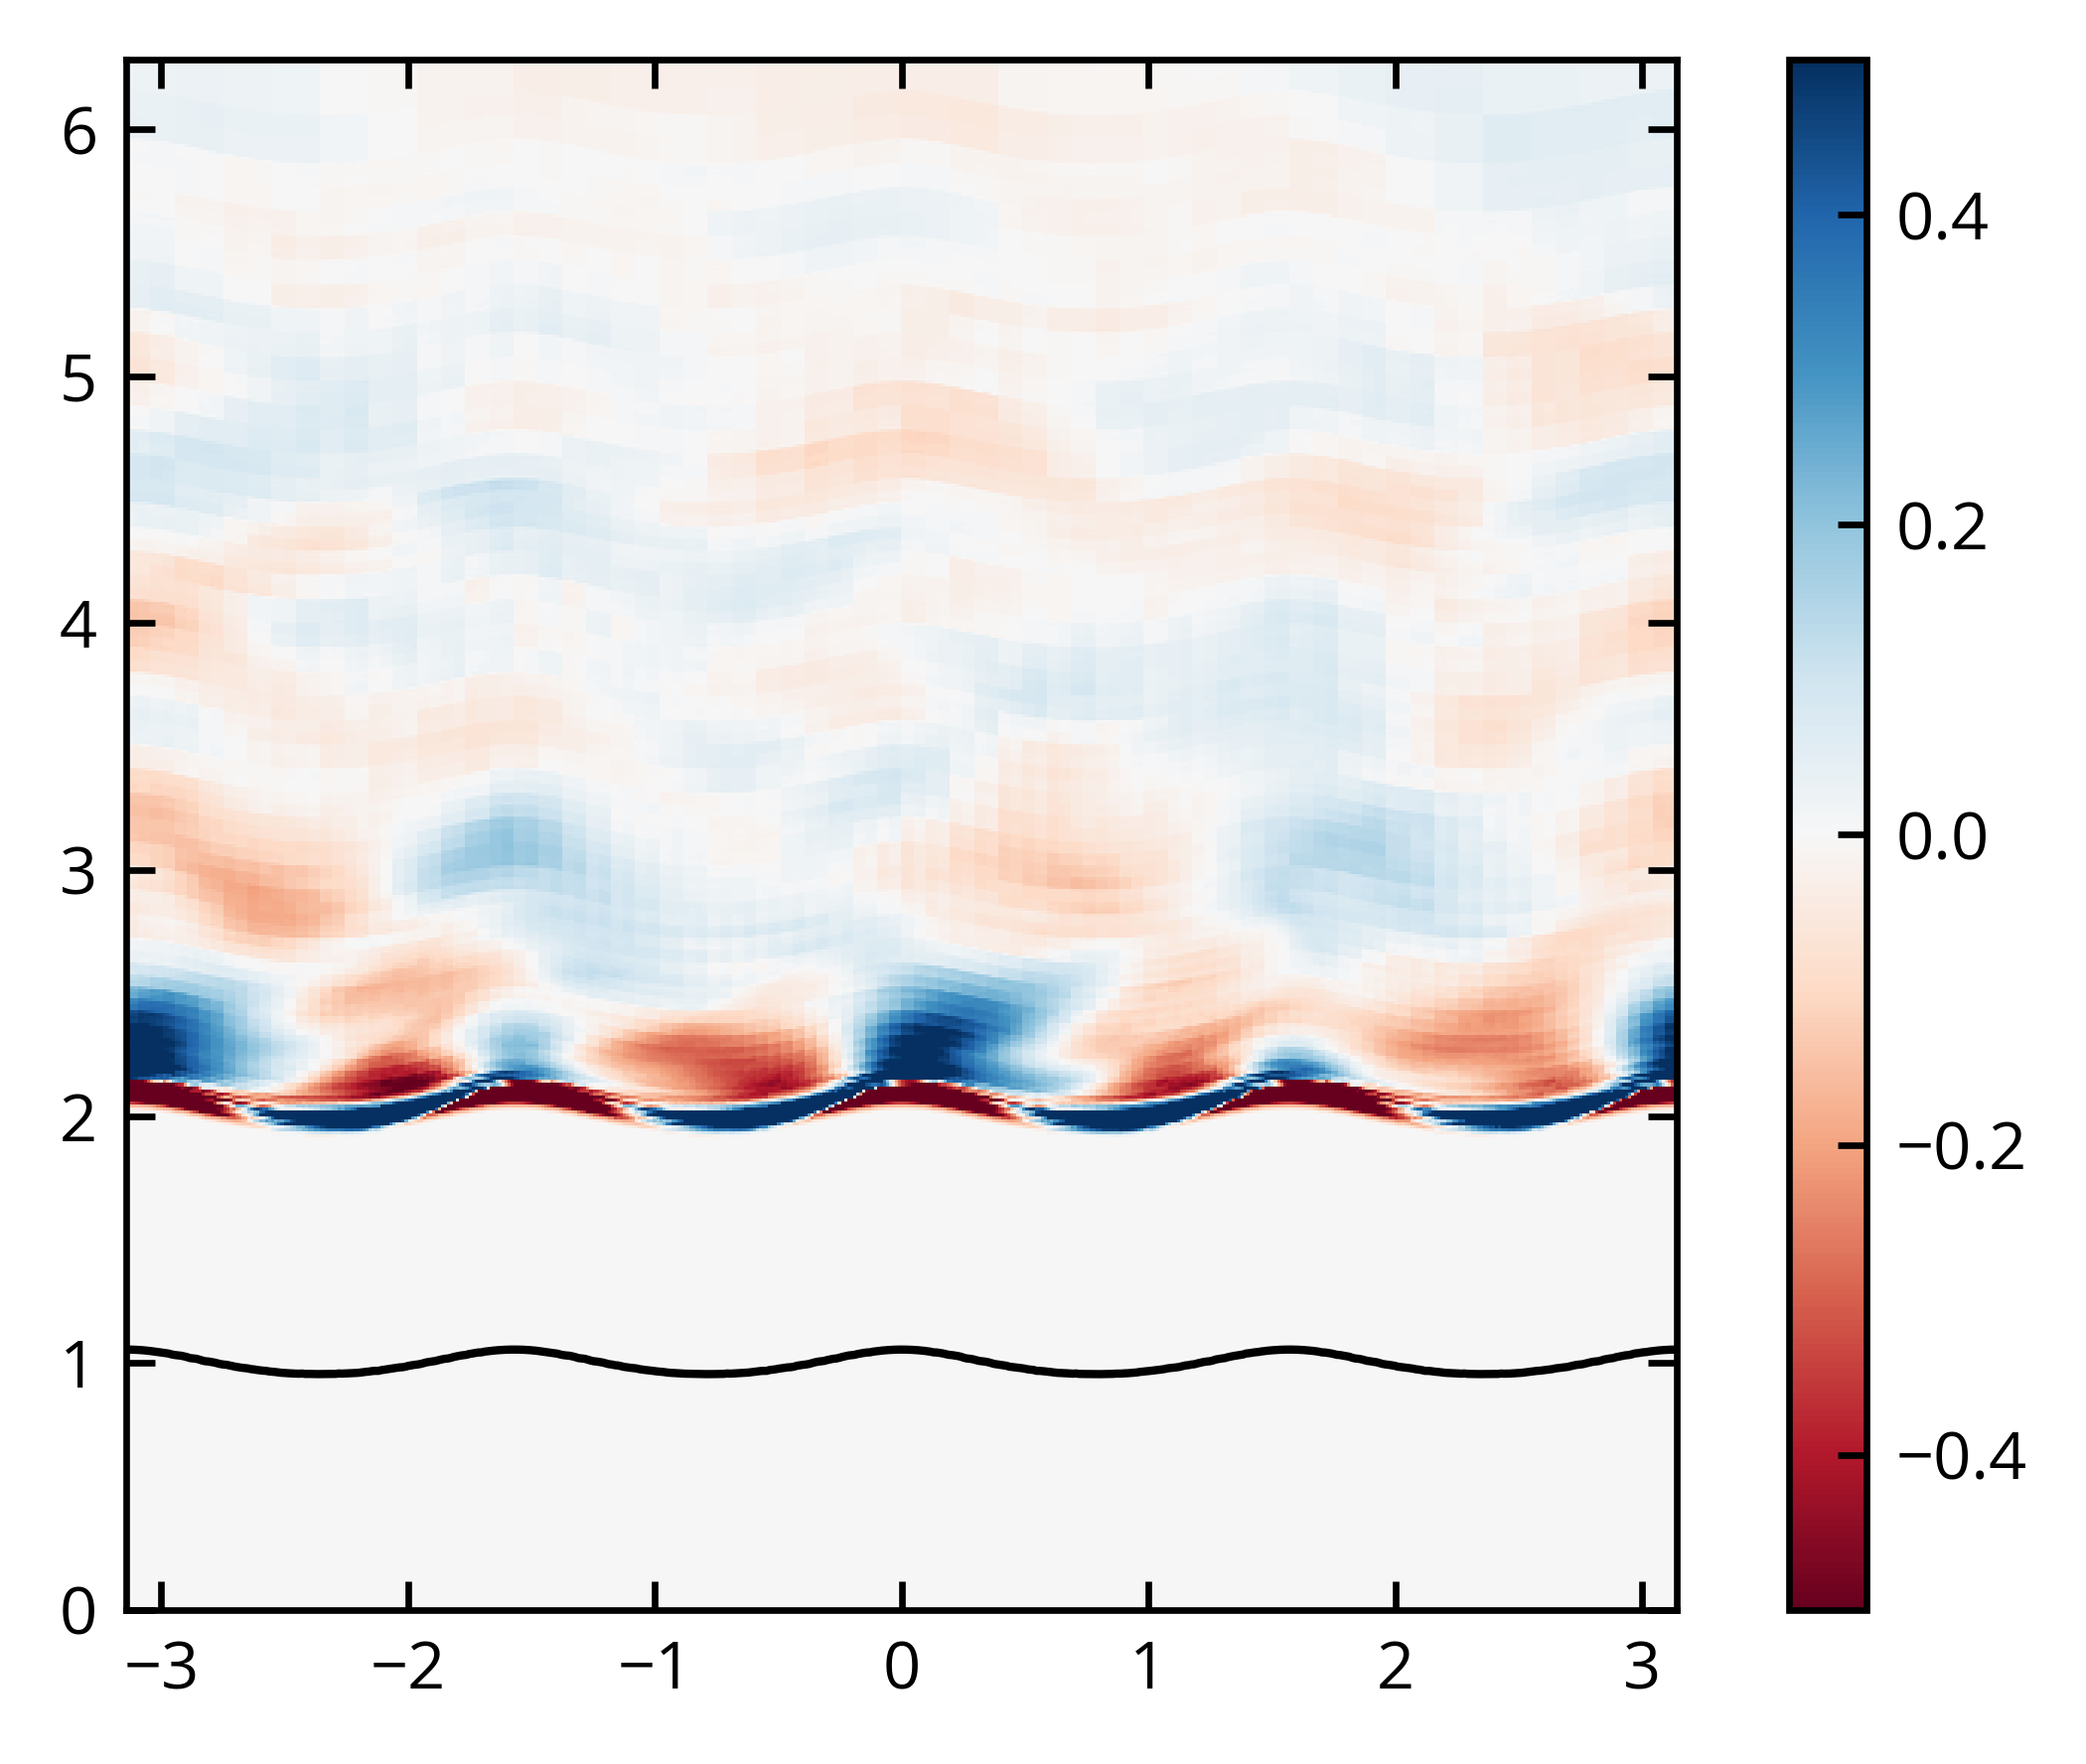

In [190]:
plt.figure(figsize=[4,3])
phase_aver_cart_ensemble = []
u_water_ensemble = []
for i in range(0,7):
    snapshot = snapshot_ensemble[i]
    u_water, u_water_interp, phase_aver_cart, phase_aver_interp, u_water_interp_1D = water_profile(snapshot.ux_2D, snapshot.eta_1D, L0=np.pi*2) 
    phase_aver_cart_ensemble.append(phase_aver_cart)

    

# for i in range(u_water.shape[0]):
#     zmax = L0/2. ; zmin = - L0/2. 
#     zgrid = np.linspace(zmin, zmax, 512)
#     z = np.linspace(-L0/2,L0/2,512) - eta[i]
#     f = interp1d(z, phase_average[i,:], fill_value='extrapolate')
#     ugrid = f(zgrid)
#     phase_aver_cart[i] = ugrid

# plt.imshow(np.rot90(phase_average)/0.25**2, cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi])
# plt.imshow(np.rot90(np.tile(ux[i], (NGRID, 1))), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi])
plt.imshow(np.rot90(np.average(phase_aver_cart_ensemble, axis=0))/0.25, cmap='RdBu', 
           extent=[-np.pi,np.pi,0,2*np.pi], vmin=-0.5, vmax=0.5)
xarray = np.linspace(-L0/2,L0/2,NGRID)
i = 2
plt.plot(xarray, snapshot_ensemble[i].eta_1D,'k',lw=1)
plt.colorbar()

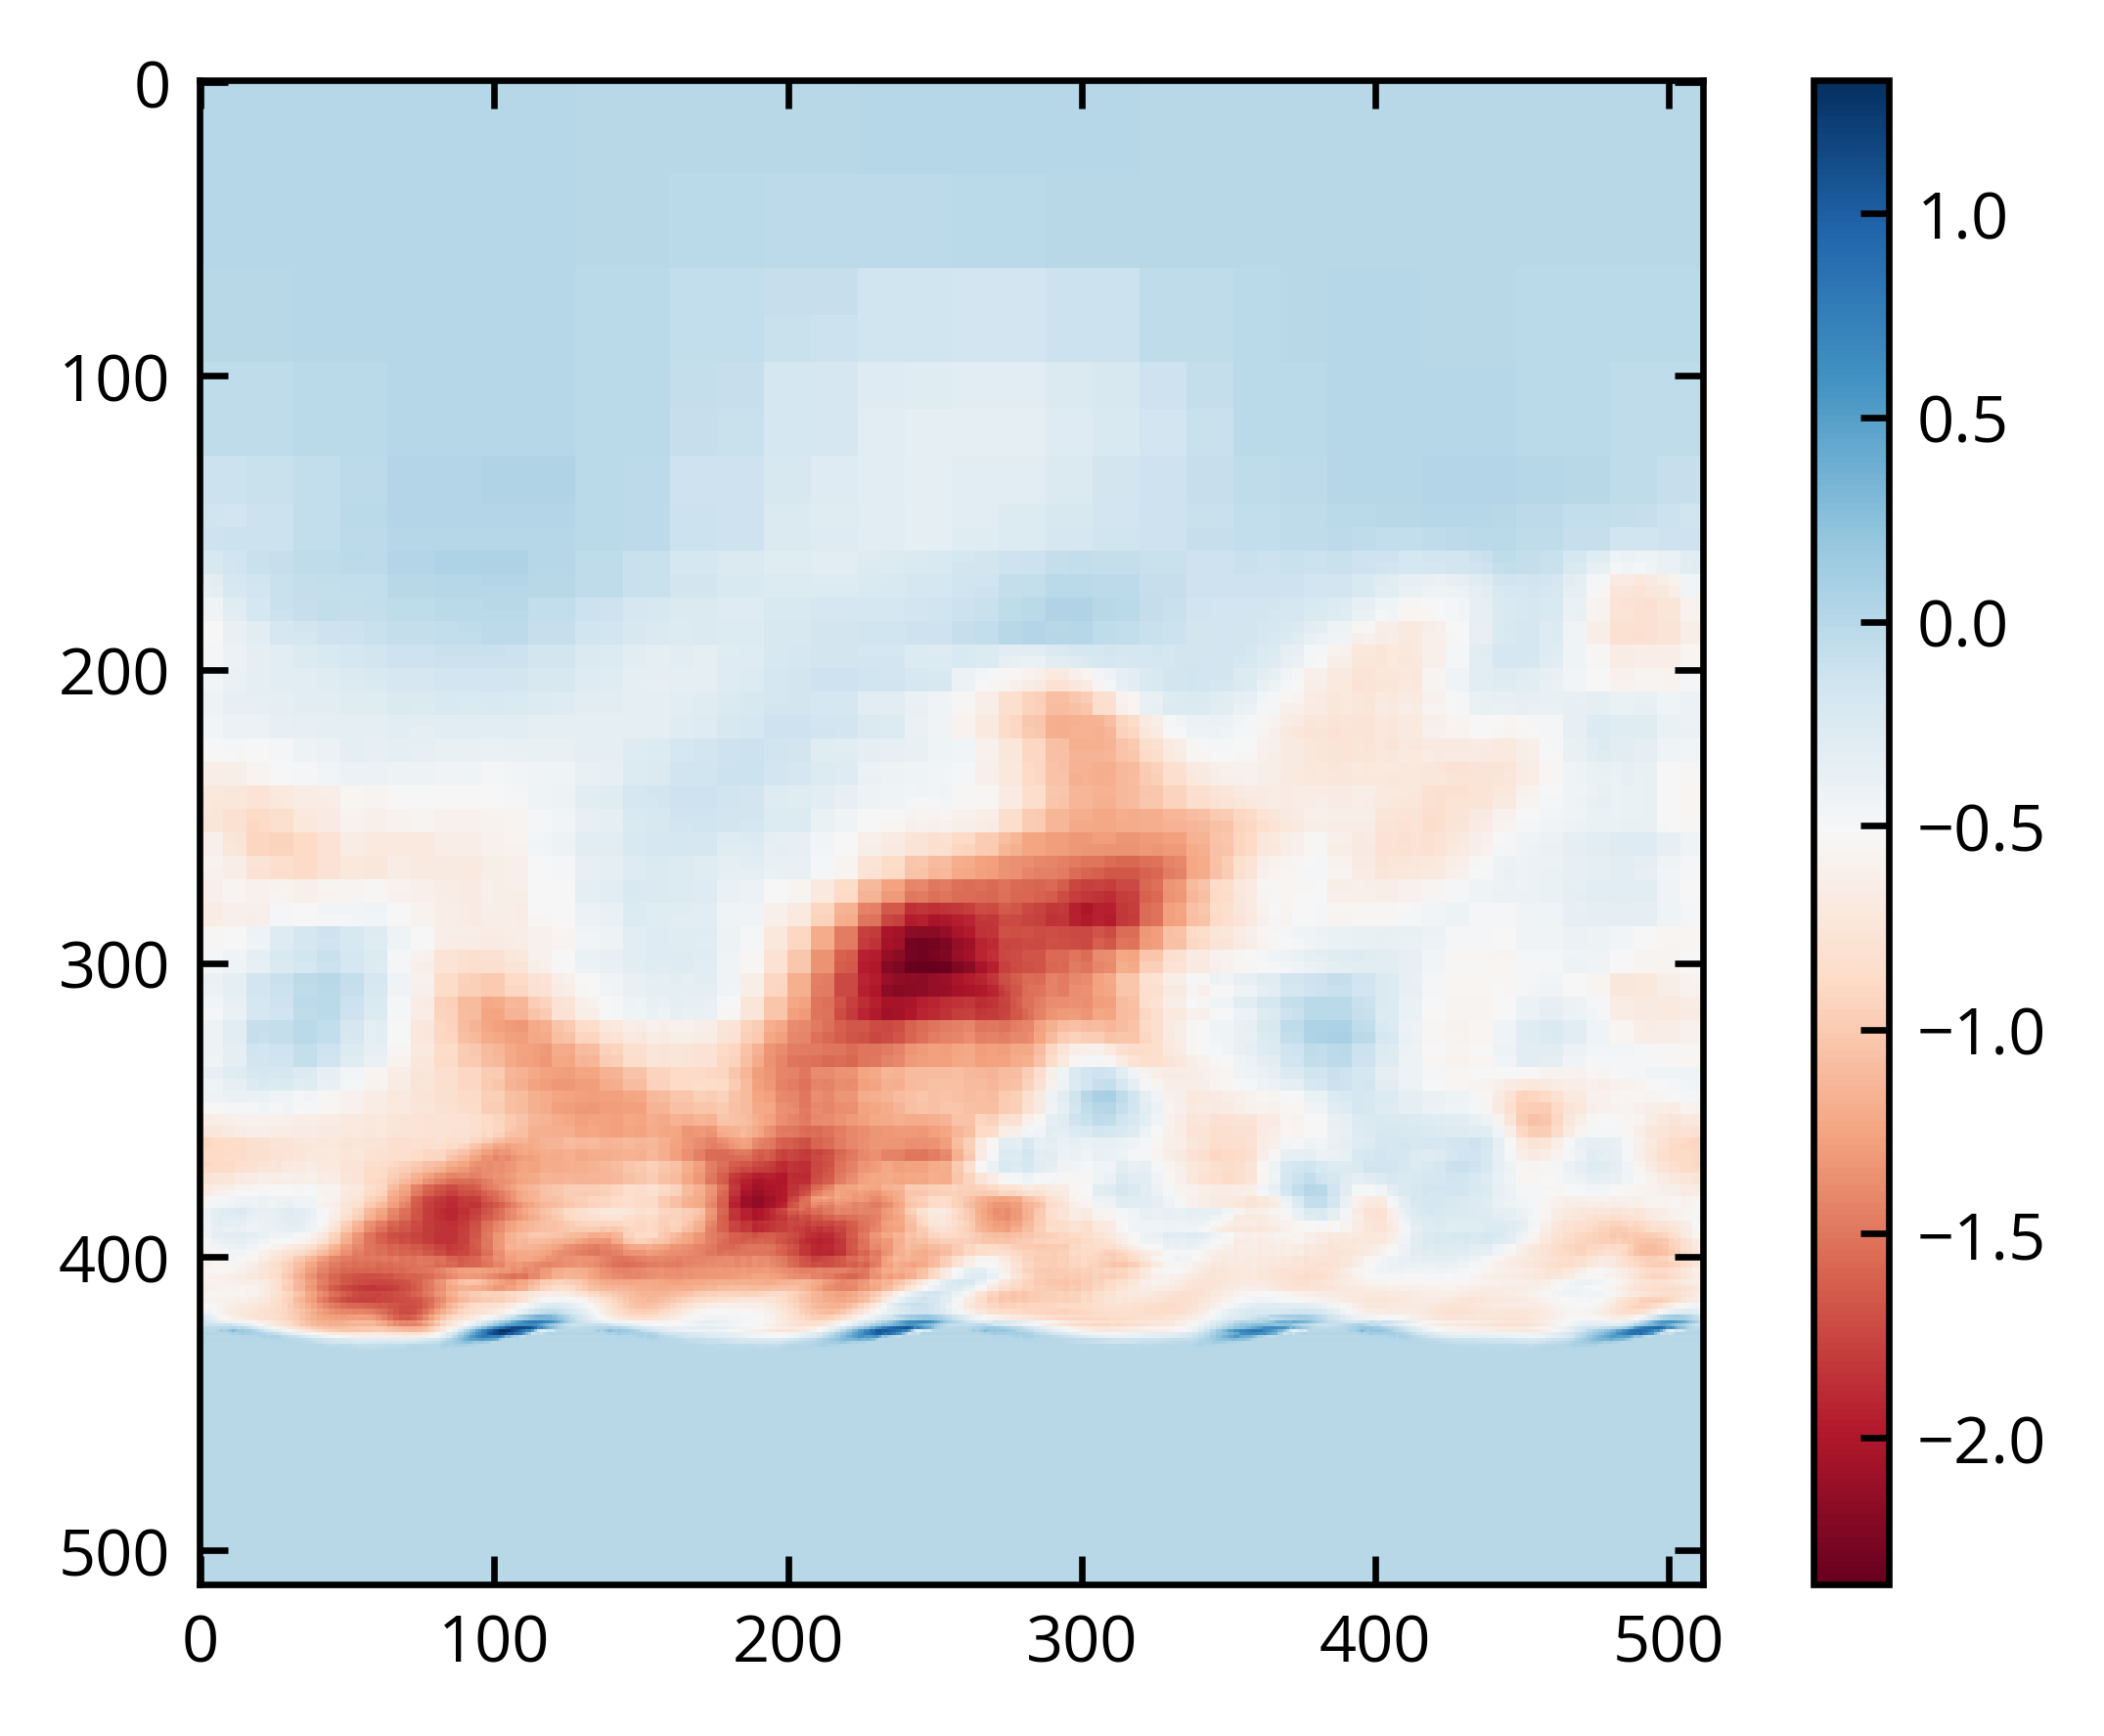

In [15]:
plt.figure(figsize=[4,3])
plt.imshow(np.rot90(snapshot_ensemble.re_stress_2D)/0.25**2,cmap='RdBu')
plt.colorbar()

In [ ]:
# TO-DO: write coordinate transformation function

In [41]:
ux = []
re_stress = []
eta = []; ux = []; uy = []
for snap in snapshot_ensemble:
    # Compute Reynolds stress
    ux_mean = np.tile(np.average(snap.ux_3D['value'], axis=(0,1)), (snap.ux_3D['value'].shape[1], 1))
    uy_mean = np.tile(np.average(snap.uy_3D['value'], axis=(0,1)), (snap.uy_3D['value'].shape[1], 1))
    re_stress_3D = (snap.ux_3D['value']-ux_mean)*(snap.uy_3D['value']-uy_mean)
    # Append z direction averaged 2D profile
    re_stress.append(np.average(re_stress_3D, axis=0))
    eta.append(snap.eta_1D)
    ux.append(np.average(snap.ux_3D['value'], axis=0)); uy.append(np.average(snap.uy_3D['value'],axis=0))
      
# plt.imshow(np.rot90(np.average(snapchat.ux_3D['value'],axis=0)), cmap='RdBu',extent=[-np.pi,np.pi,0,2*np.pi])
# x = np.average(snapchat.x_tile,axis=0)
# plt.plot(x,snapchat.eta_1D,color='k',lw=0.5)

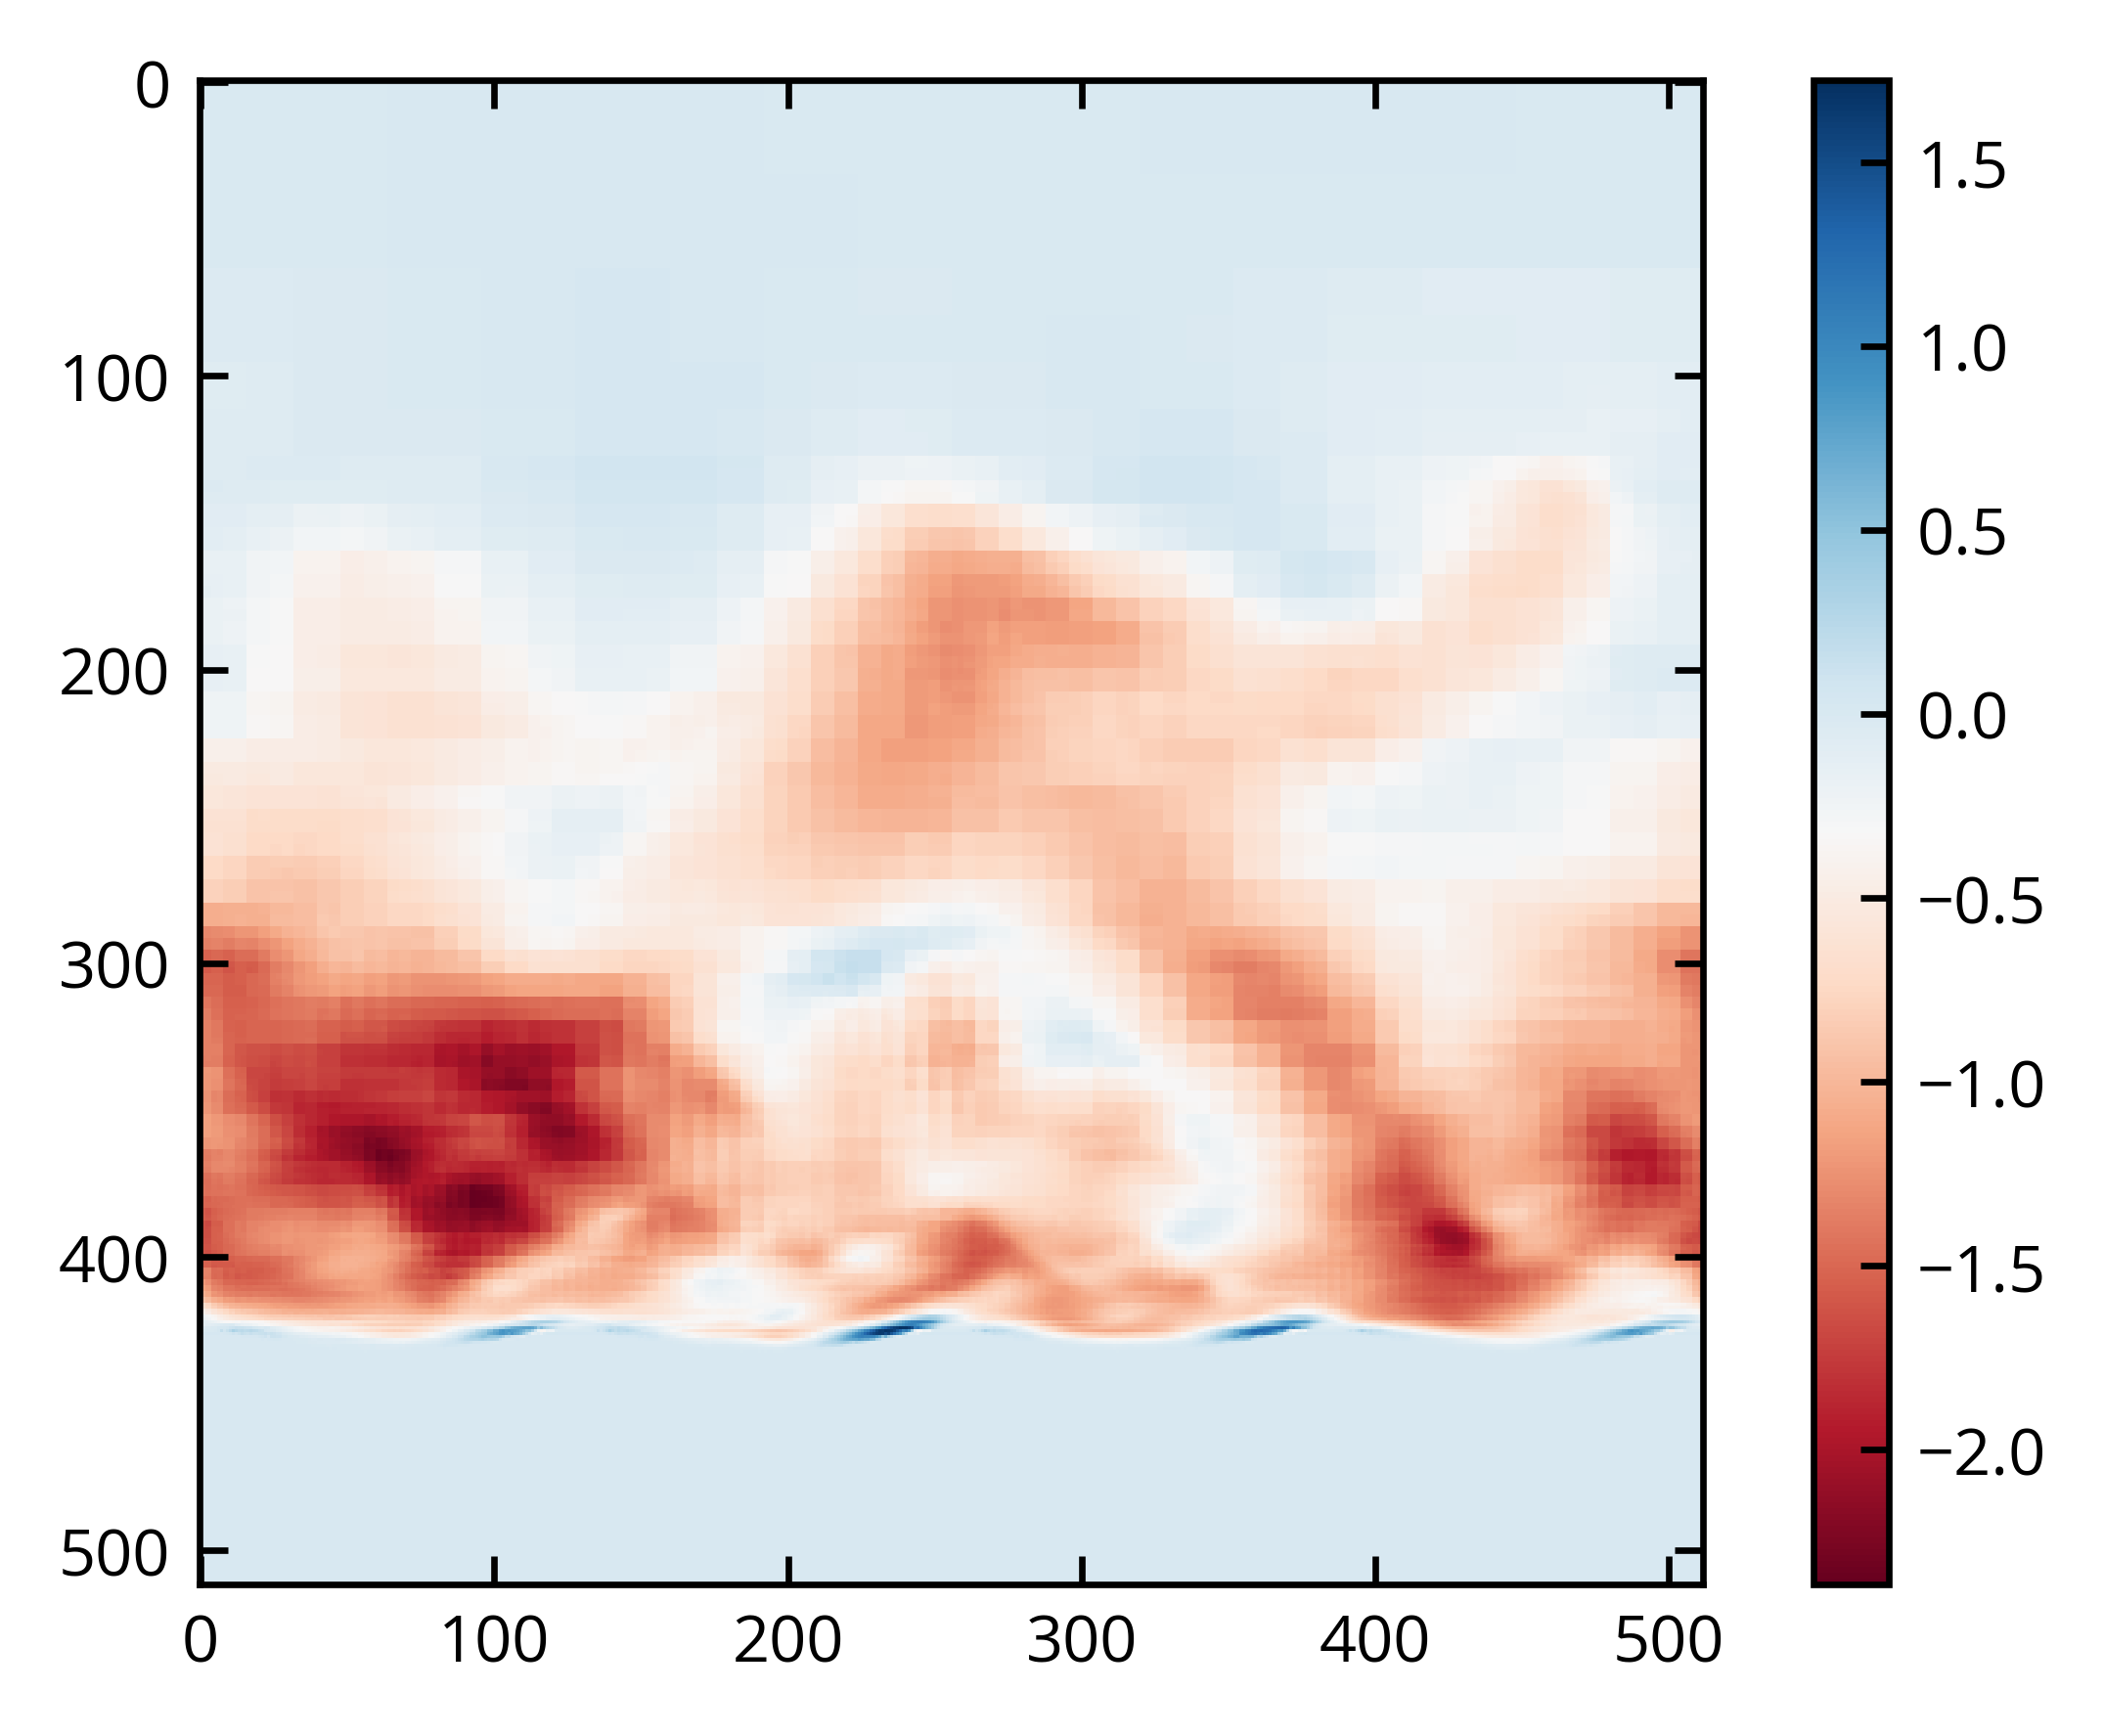

In [15]:
plt.figure(figsize=[4,3])
plt.imshow(np.rot90(re_stress[3]/0.25**2), cmap='RdBu')
plt.colorbar()

In [27]:
snapshot = snapshot_ensemble[0]
plt.figure(figsize=[4,3])
plt.imshow(np.rot90(snapshot.ux_2D/0.25), cmap='RdBu', extent=[-np.pi,np.pi,0,2*np.pi])
L0 = 2*np.pi; NGRID = 512
xarray = np.linspace(-L0/2,L0/2,NGRID)
plt.plot(xarray, snapshot.eta_1D,'k',lw=1)
plt.colorbar()
cbar.ax.text(-0.7, 0, r'$v/u_*$', ha='center', va='center')

NameError: name 'snapshot_ensemble' is not defined

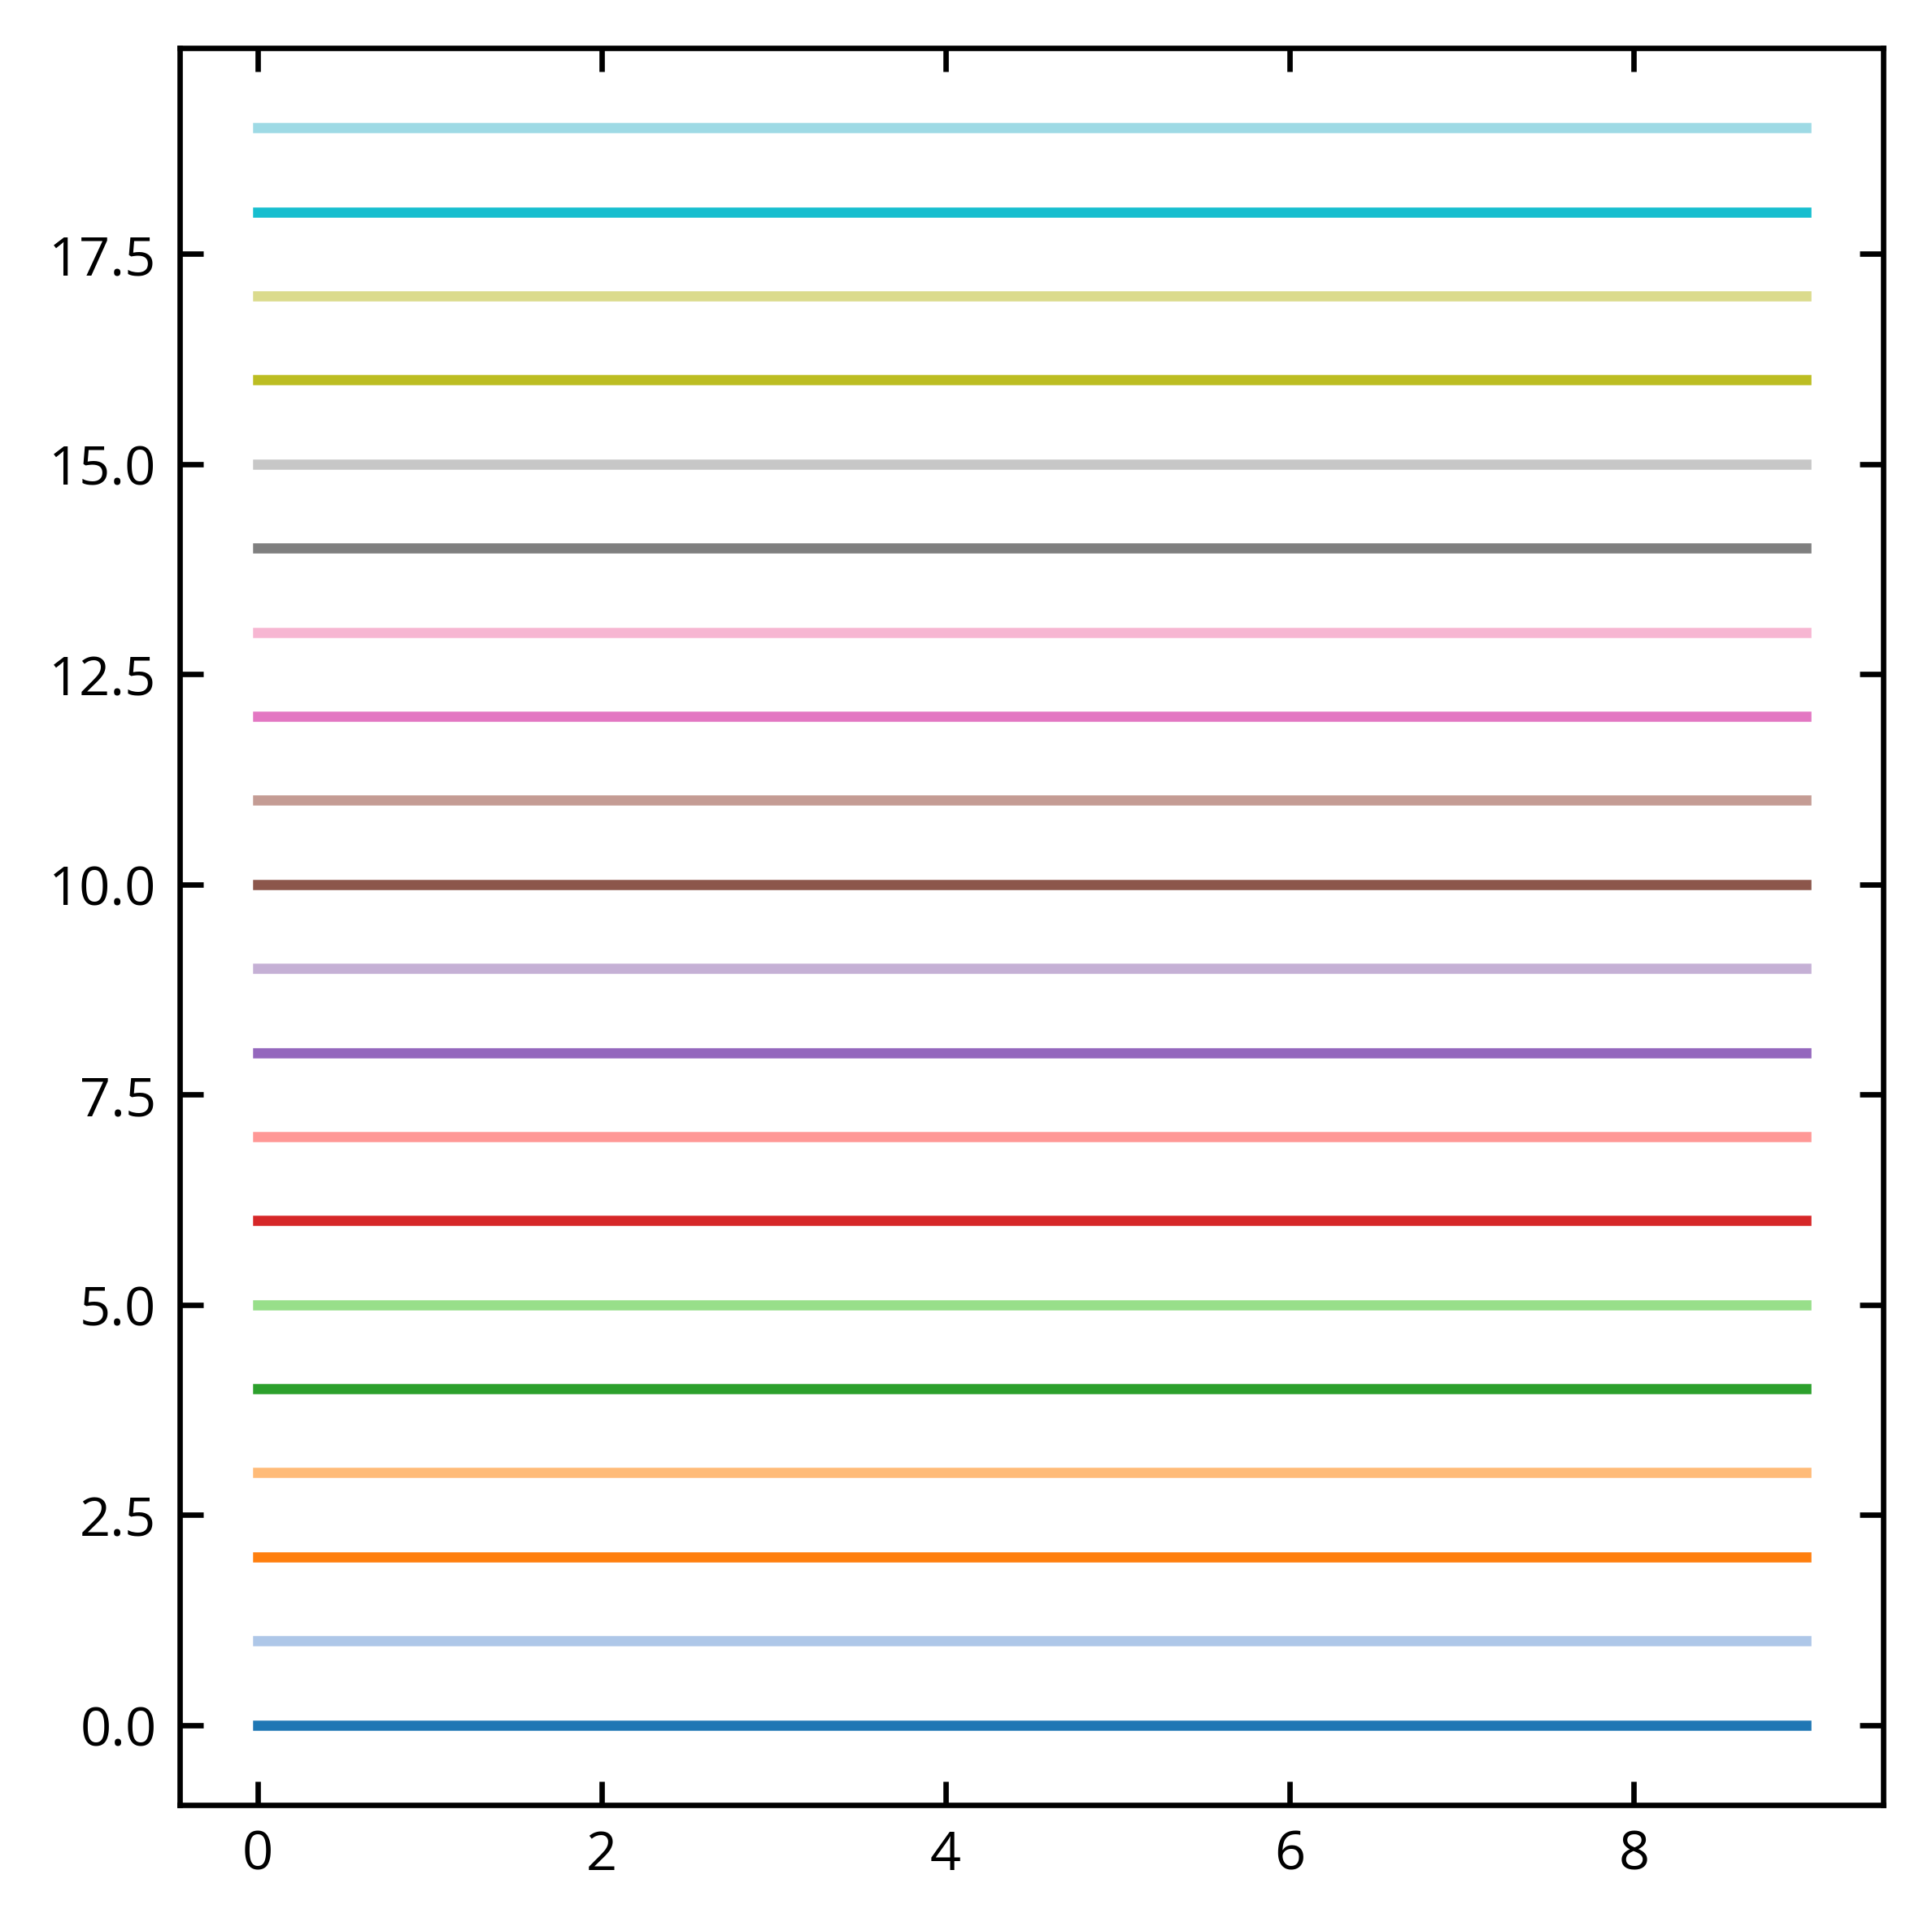

In [238]:
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']
for i in range(0,20):
    plt.plot(np.ones(10)*i, color=color_sequence[i])

No handles with labels found to put in legend.


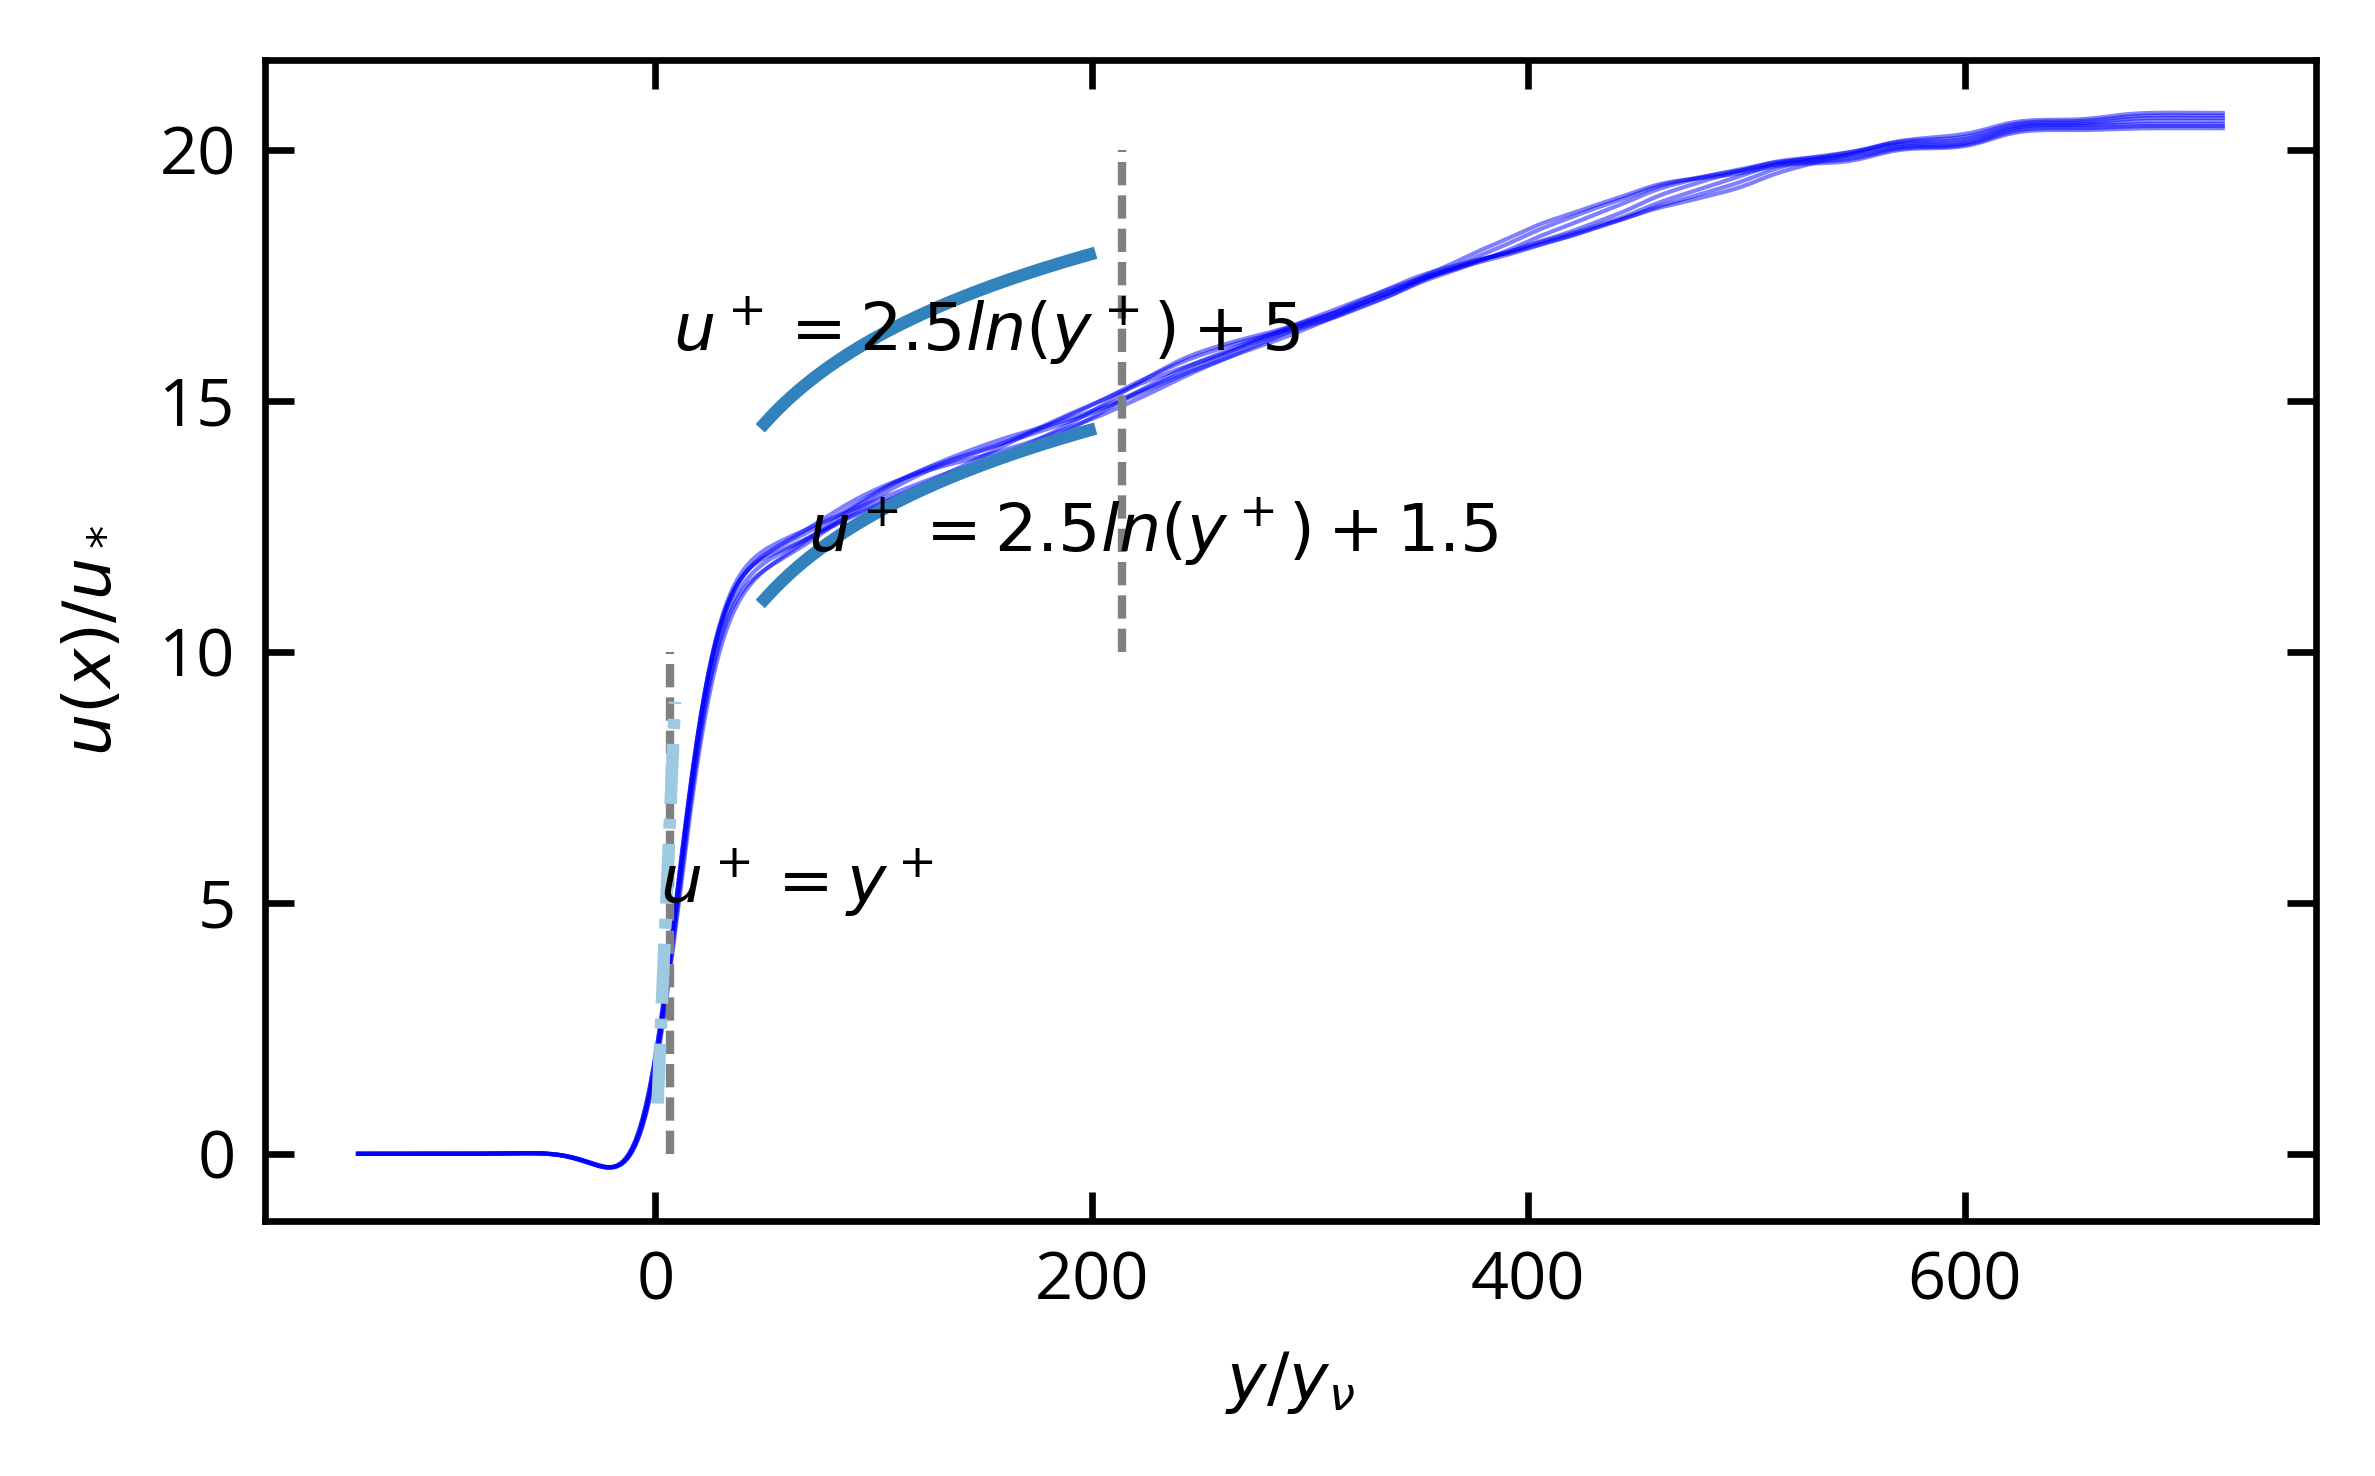

In [270]:
plt.figure(figsize=(4,2.5))
ux1 = []; ux2 = []; ux3 = []; ux4 = []
y_tau = (2*np.pi-1)/720
u_tau = 0.25

yarray1 = np.linspace(0,L0,512,endpoint=False)+L0/2**N/2
for i in range(0,7):
    ux_i = snapshot_ensemble_720[i].ux_1D
    ux_i = butter_lowpass_filter(ux_i)
    plt.plot((yarray1-1)/y_tau, ux_i/u_tau, c='blue', alpha=0.5, lw=0.5)
    ux1.append(ux_i)

# plt.plot((yarray1-1)/y_tau, np.average(ux1,axis=0)/u_tau, c='blue')
# plt.plot((yarray2-1)/y_tau, np.average(ux2,axis=0)/u_tau, c='red')
plt.plot(np.ones(100)*(0.2/4)/y_tau, np.linspace(0,10,100), '--', c='gray',lw=1)
plt.plot(np.ones(100)*(2*np.pi/4)/y_tau, np.linspace(10,20,100), '--', c='gray',lw=1)
y = np.arange(50,200)
plt.plot(y, 1/0.41*np.log(y)+5, color=plt.get_cmap('tab20c')(0))
plt.text(8,16, r'$u^+=2.5ln(y^+)+5$')
# plt.plot(y, 1/0.41*np.log(y)+1.5, color=plt.get_cmap('tab20c')(0))
# plt.text(70,10, r'$u^+=2.5ln(y^+)+1.5$')
plt.plot(y, 1/0.41*np.log(y)+1.5, color=plt.get_cmap('tab20c')(0))
plt.text(70,12, r'$u^+=2.5ln(y^+)+1.5$')
y = np.arange(1,10)
plt.plot(y, y, '-.', color=plt.get_cmap('tab20c')(2))
plt.text(2,5, r'$u^+=y^+$')
# plt.xscale('log'); 
plt.ylabel(r'$u(x)/u_*$'); plt.xlabel(r'$y/y_{\nu}$'); plt.legend(loc='upper left')

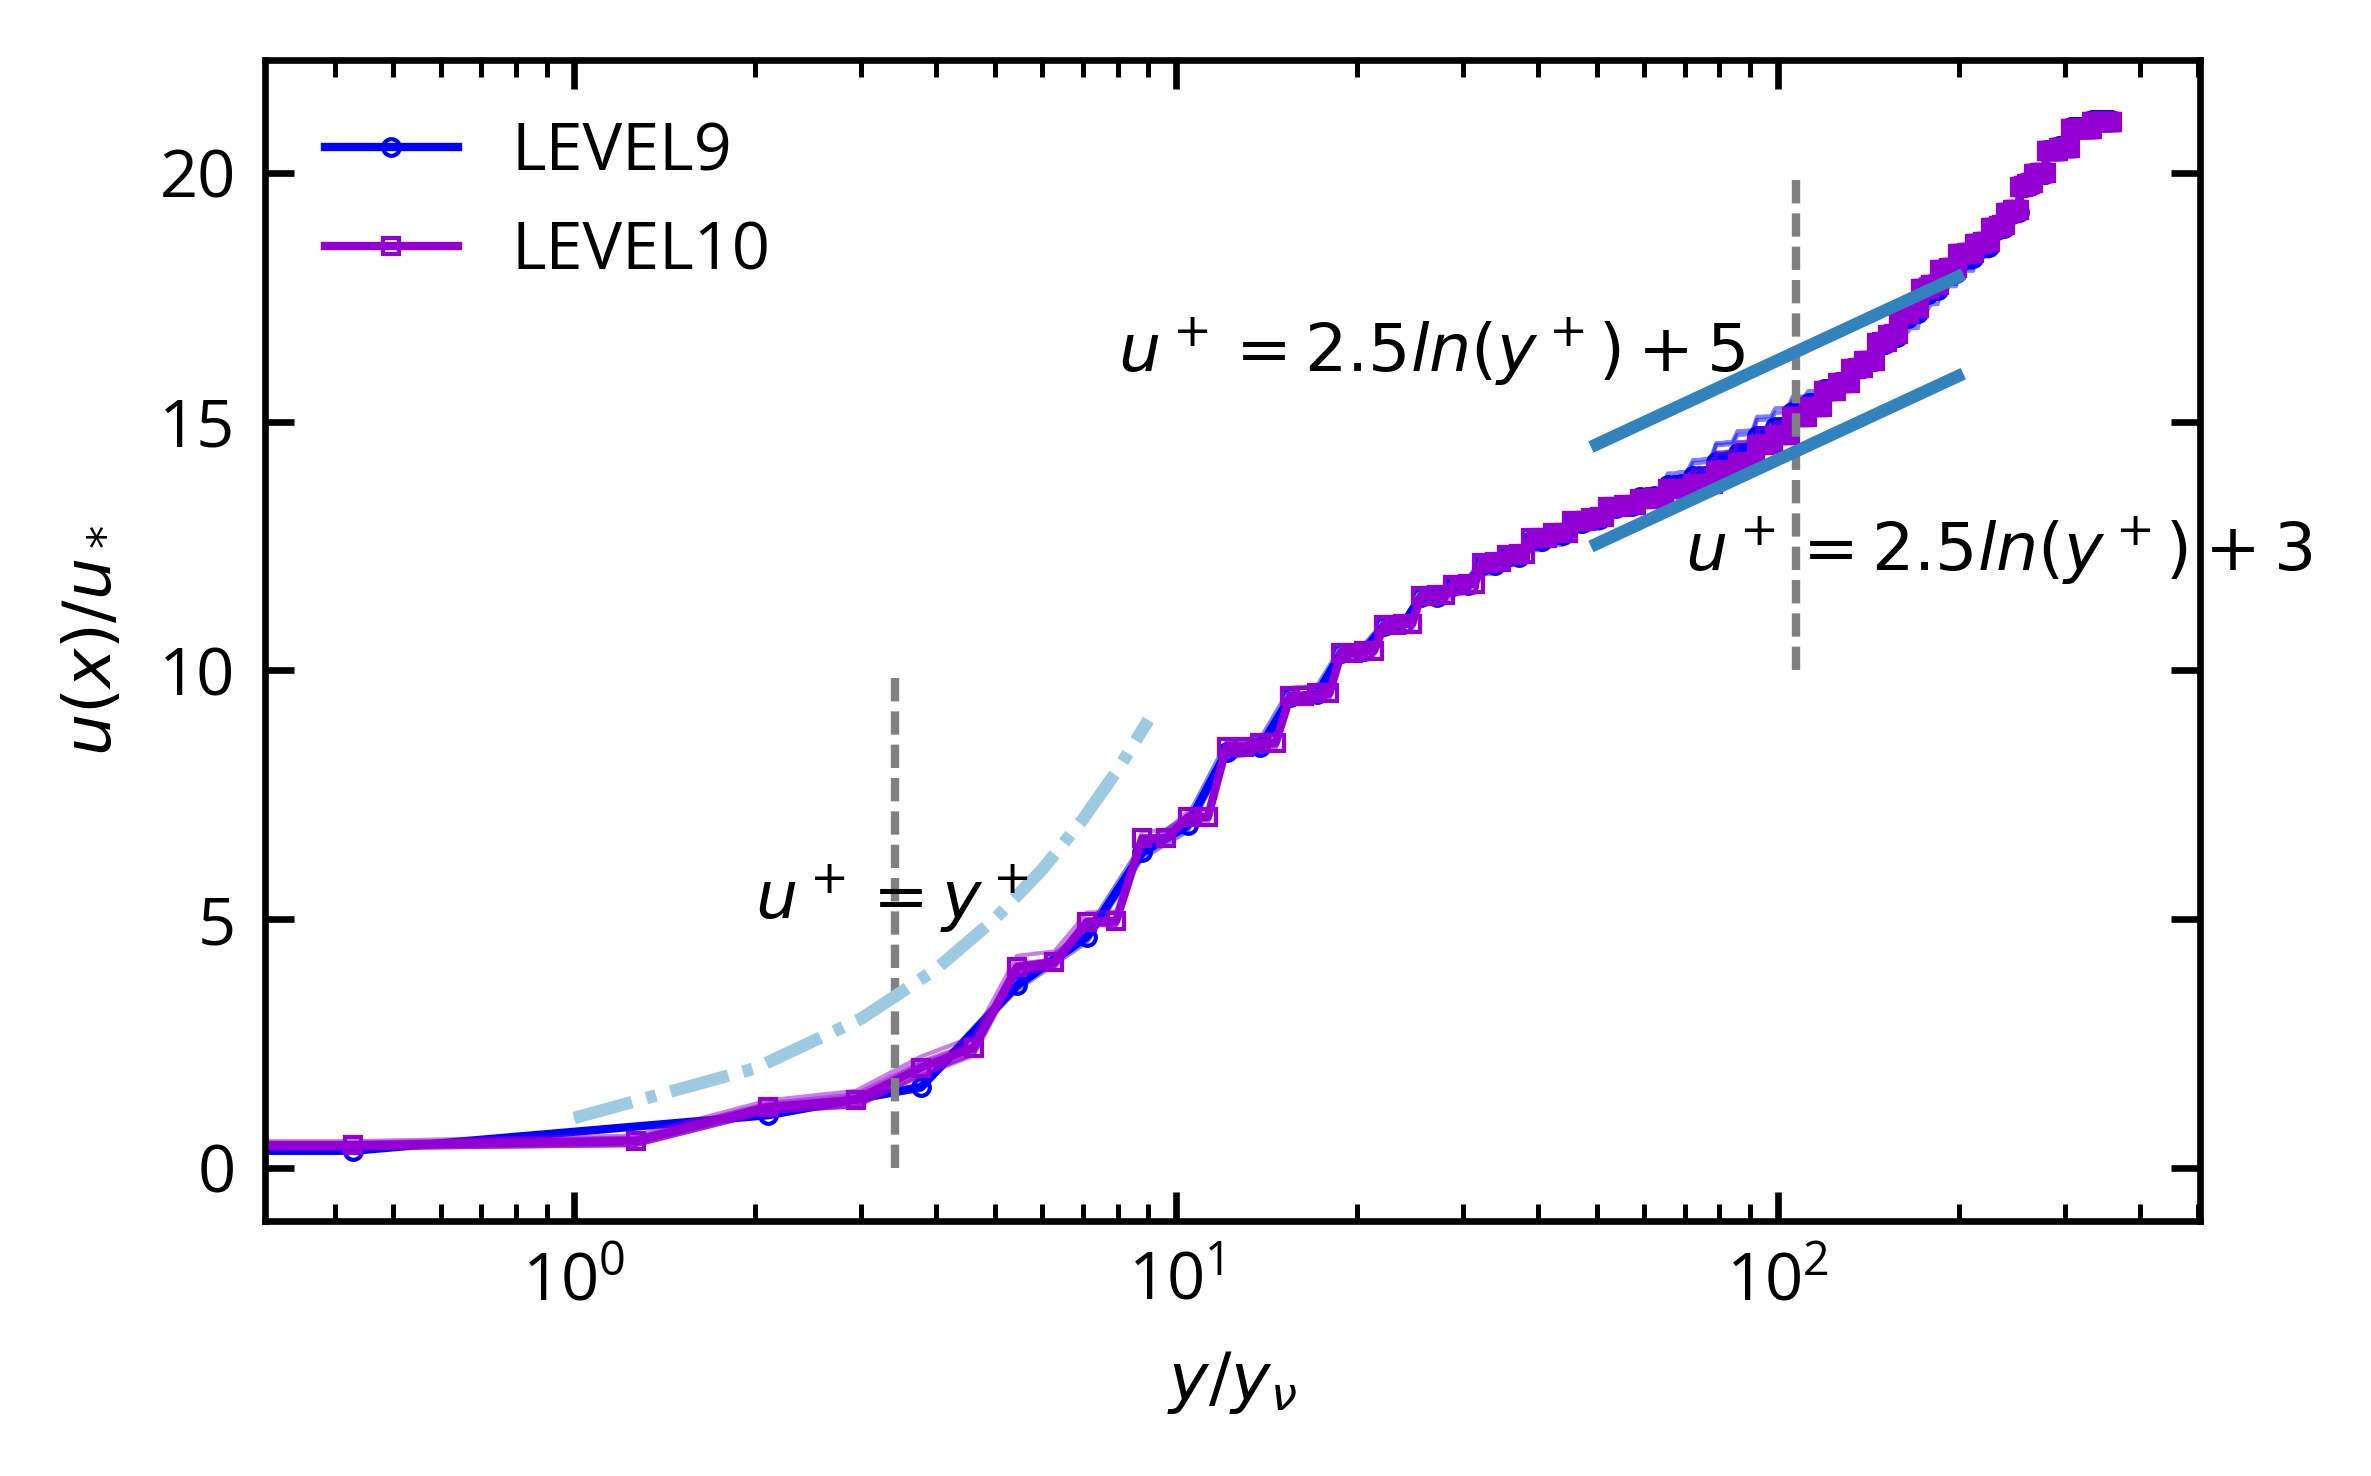

In [40]:
plt.figure(figsize=(4,2.5))
L0 = 2*np.pi
ux1 = []; ux2 = []; ux3 = []; ux4 = []
y_tau = (2*np.pi-1)/360
u_tau = 0.25

N = 256
yarray1 = np.linspace(0,L0,N,endpoint=False)+L0/2**N/2
for i in range(0,7):
    ux_i = snapshot_ensemble[i].ux_1D
#     ux_i = butter_lowpass_filter(ux_i)
    plt.plot((yarray1-1)/y_tau, ux_i/u_tau, c='blue', alpha=0.5, lw=0.5)
    ux1.append(ux_i)
plt.plot((yarray1-1)/y_tau, np.average(ux1,axis=0)/u_tau, c='blue', label = 'LEVEL9', lw=1,
        marker = 'o', mfc='none', markeredgewidth=0.5, markersize=2)

N = 512
yarray2 = np.linspace(0,L0,N,endpoint=False)+L0/2**N/2
for i in range(0,6):
    ux_i = snapshot_ensemble_36_10[i].ux_1D
#     ux_i = butter_lowpass_filter(ux_i)
    plt.plot((yarray2-1)/y_tau, ux_i/u_tau, c='darkviolet',
             alpha=0.5, lw=0.5)
    ux2.append(ux_i)    
plt.plot((yarray2-1)/y_tau, np.average(ux2,axis=0)/u_tau, c='darkviolet', label = 'LEVEL10', lw=1,
        marker = 's', mfc='none', markeredgewidth=0.5, markersize=2)

plt.plot(np.ones(100)*(0.2/4)/y_tau, np.linspace(0,10,100), '--', c='gray',lw=1)
plt.plot(np.ones(100)*(2*np.pi/4)/y_tau, np.linspace(10,20,100), '--', c='gray',lw=1)
y = np.arange(50,200)
plt.plot(y, 1/0.41*np.log(y)+5, color=plt.get_cmap('tab20c')(0))
plt.text(8,16, r'$u^+=2.5ln(y^+)+5$')
# plt.plot(y, 1/0.41*np.log(y)+1.5, color=plt.get_cmap('tab20c')(0))
# plt.text(70,10, r'$u^+=2.5ln(y^+)+1.5$')
plt.plot(y, 1/0.41*np.log(y)+3, color=plt.get_cmap('tab20c')(0))
plt.text(70,12, r'$u^+=2.5ln(y^+)+3$')
y = np.arange(1,10)
plt.plot(y, y, '-.', color=plt.get_cmap('tab20c')(2))
plt.text(2,5, r'$u^+=y^+$')
plt.xscale('log')
plt.ylabel(r'$u(x)/u_*$'); plt.xlabel(r'$y/y_{\nu}$'); plt.legend(loc='upper left')

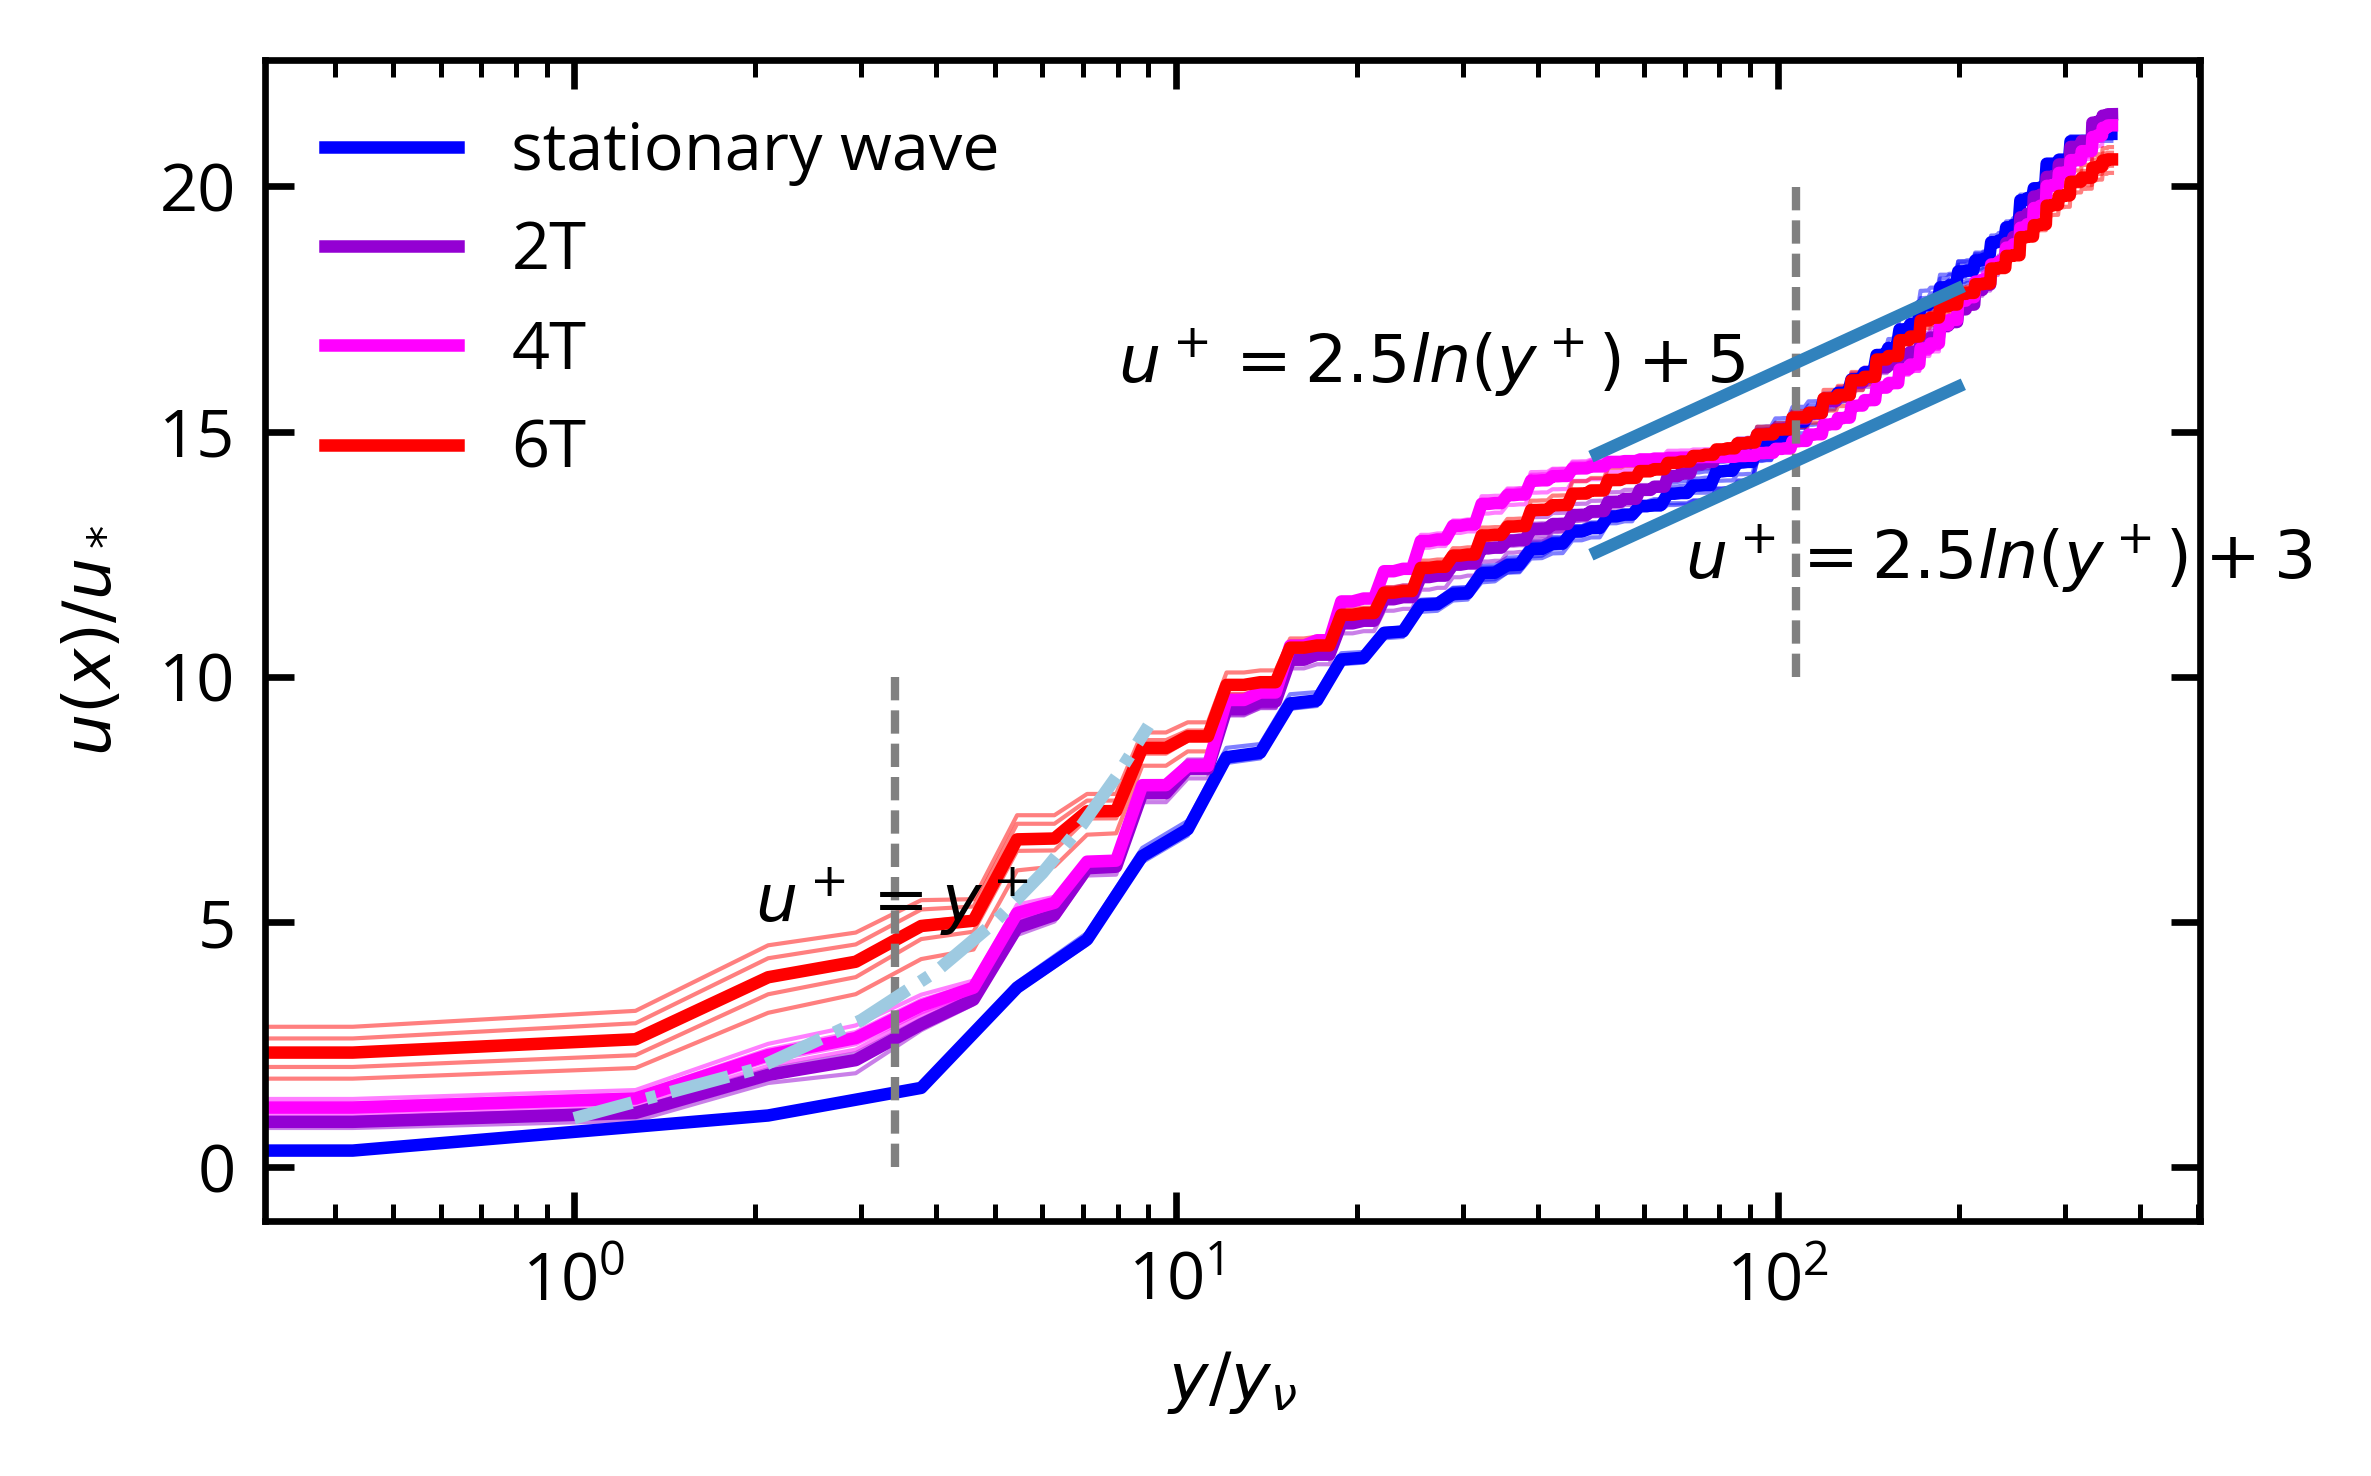

In [50]:
plt.figure(figsize=(4,2.5))
ux1 = []; ux2 = []; ux3 = []; ux4 = []
y_tau = (2*np.pi-1)/360
u_tau = 0.25

N = 256
yarray1 = np.linspace(0,L0,256,endpoint=False)+L0/2**N/2
for i in range(0,7):
    ux_i = snapshot_ensemble[i].ux_1D
#     ux_i = butter_lowpass_filter(ux_i)
    plt.plot((yarray1-1)/y_tau, ux_i/u_tau, c='blue', alpha=0.5, lw=0.5)
    ux1.append(ux_i)

N = 512
yarray2 = np.linspace(0,L0,512,endpoint=False)+L0/2**N/2
for i in range(4,9):
    ux_i = snapshot_ensemble_360_moving_MU16[i].ux_1D
#     plt.plot(ux_i, yarray*k, '--', c='blue', alpha=0.5, lw=0.5)
#     ux_i = butter_lowpass_filter(ux_i)
    plt.plot((yarray2-1)/y_tau, ux_i/u_tau, c='darkviolet',
             alpha=0.5, lw=0.5)
    ux2.append(ux_i)
    
for i in range(10,15):
    ux_i = snapshot_ensemble_360_moving_MU16[i].ux_1D
#     plt.plot(ux_i, yarray*k, '--', c='blue', alpha=0.5, lw=0.5)
#     ux_i = butter_lowpass_filter(ux_i)
    plt.plot((yarray2-1)/y_tau, ux_i/u_tau, c='magenta', alpha=0.5, lw=0.5)
    ux3.append(ux_i)
    
for i in range(16,21):
    ux_i = snapshot_ensemble_360_moving_MU16[i].ux_1D
#     plt.plot(ux_i, yarray*k, '--', c='blue', alpha=0.5, lw=0.5)
#     ux_i = butter_lowpass_filter(ux_i)
    plt.plot((yarray2-1)/y_tau, ux_i/u_tau, c='red', alpha=0.5, lw=0.5)
    ux4.append(ux_i)

plt.plot((yarray1-1)/y_tau, np.average(ux1,axis=0)/u_tau, c='blue', label = 'stationary wave')
plt.plot((yarray2-1)/y_tau, np.average(ux2,axis=0)/u_tau, c='darkviolet', label = '2T')
plt.plot((yarray2-1)/y_tau, np.average(ux3,axis=0)/u_tau, c='magenta', label = '4T')
plt.plot((yarray2-1)/y_tau, np.average(ux4,axis=0)/u_tau, c='red', label = '6T')
plt.plot(np.ones(100)*(0.2/4)/y_tau, np.linspace(0,10,100), '--', c='gray',lw=1)
plt.plot(np.ones(100)*(2*np.pi/4)/y_tau, np.linspace(10,20,100), '--', c='gray',lw=1)
y = np.arange(50,200)
plt.plot(y, 1/0.41*np.log(y)+5, color=plt.get_cmap('tab20c')(0))
plt.text(8,16, r'$u^+=2.5ln(y^+)+5$')
# plt.plot(y, 1/0.41*np.log(y)+1.5, color=plt.get_cmap('tab20c')(0))
# plt.text(70,10, r'$u^+=2.5ln(y^+)+1.5$')
plt.plot(y, 1/0.41*np.log(y)+3, color=plt.get_cmap('tab20c')(0))
plt.text(70,12, r'$u^+=2.5ln(y^+)+3$')
y = np.arange(1,10)
plt.plot(y, y, '-.', color=plt.get_cmap('tab20c')(2))
plt.text(2,5, r'$u^+=y^+$')
plt.xscale('log')
plt.ylabel(r'$u(x)/u_*$'); plt.xlabel(r'$y/y_{\nu}$'); plt.legend(loc='upper left')

In [ ]:
plt.figure(figsize=(4,2.5))
ux1 = []; ux2 = []; ux3 = []; ux4 = []
y_tau = (2*np.pi-1)/360
u_tau = 0.25

N = 256
yarray1 = np.linspace(0,L0,256,endpoint=False)+L0/2**N/2
for i in range(0,7):
    ux_i = snapshot_ensemble[i].ux_1D
#     ux_i = butter_lowpass_filter(ux_i)
    plt.plot((yarray1-1)/y_tau, ux_i/u_tau, c='blue', alpha=0.5, lw=0.5)
    ux1.append(ux_i)

N = 512
yarray2 = np.linspace(0,L0,512,endpoint=False)+L0/2**N/2
for i in range(4,9):
    ux_i = snapshot_ensemble_360_moving_MU16[i].ux_1D
#     plt.plot(ux_i, yarray*k, '--', c='blue', alpha=0.5, lw=0.5)
#     ux_i = butter_lowpass_filter(ux_i)
    plt.plot((yarray2-1)/y_tau, ux_i/u_tau, c='darkviolet',
             alpha=0.5, lw=0.5)
    ux2.append(ux_i)
    
for i in range(10,15):
    ux_i = snapshot_ensemble_360_moving_MU16[i].ux_1D
#     plt.plot(ux_i, yarray*k, '--', c='blue', alpha=0.5, lw=0.5)
#     ux_i = butter_lowpass_filter(ux_i)
    plt.plot((yarray2-1)/y_tau, ux_i/u_tau, c='magenta', alpha=0.5, lw=0.5)
    ux3.append(ux_i)
    
for i in range(16,21):
    ux_i = snapshot_ensemble_360_moving_MU16[i].ux_1D
#     plt.plot(ux_i, yarray*k, '--', c='blue', alpha=0.5, lw=0.5)
#     ux_i = butter_lowpass_filter(ux_i)
    plt.plot((yarray2-1)/y_tau, ux_i/u_tau, c='red', alpha=0.5, lw=0.5)
    ux4.append(ux_i)

plt.plot((yarray1-1)/y_tau, np.average(ux1,axis=0)/u_tau, c='blue', label = 'stationary wave')
plt.plot((yarray2-1)/y_tau, np.average(ux2,axis=0)/u_tau, c='darkviolet', label = '2T')
plt.plot((yarray2-1)/y_tau, np.average(ux3,axis=0)/u_tau, c='magenta', label = '4T')
plt.plot((yarray2-1)/y_tau, np.average(ux4,axis=0)/u_tau, c='red', label = '6T')
plt.plot(np.ones(100)*(0.2/4)/y_tau, np.linspace(0,10,100), '--', c='gray',lw=1)
plt.plot(np.ones(100)*(2*np.pi/4)/y_tau, np.linspace(10,20,100), '--', c='gray',lw=1)
y = np.arange(50,200)
plt.plot(y, 1/0.41*np.log(y)+5, color=plt.get_cmap('tab20c')(0))
plt.text(8,16, r'$u^+=2.5ln(y^+)+5$')
# plt.plot(y, 1/0.41*np.log(y)+1.5, color=plt.get_cmap('tab20c')(0))
# plt.text(70,10, r'$u^+=2.5ln(y^+)+1.5$')
plt.plot(y, 1/0.41*np.log(y)+3, color=plt.get_cmap('tab20c')(0))
plt.text(70,12, r'$u^+=2.5ln(y^+)+3$')
y = np.arange(1,10)
plt.plot(y, y, '-.', color=plt.get_cmap('tab20c')(2))
plt.text(2,5, r'$u^+=y^+$')
plt.xscale('log')
plt.ylabel(r'$u(x)/u_*$'); plt.xlabel(r'$y/y_{\nu}$'); plt.legend(loc='upper left')

(-0.2, 1.5)

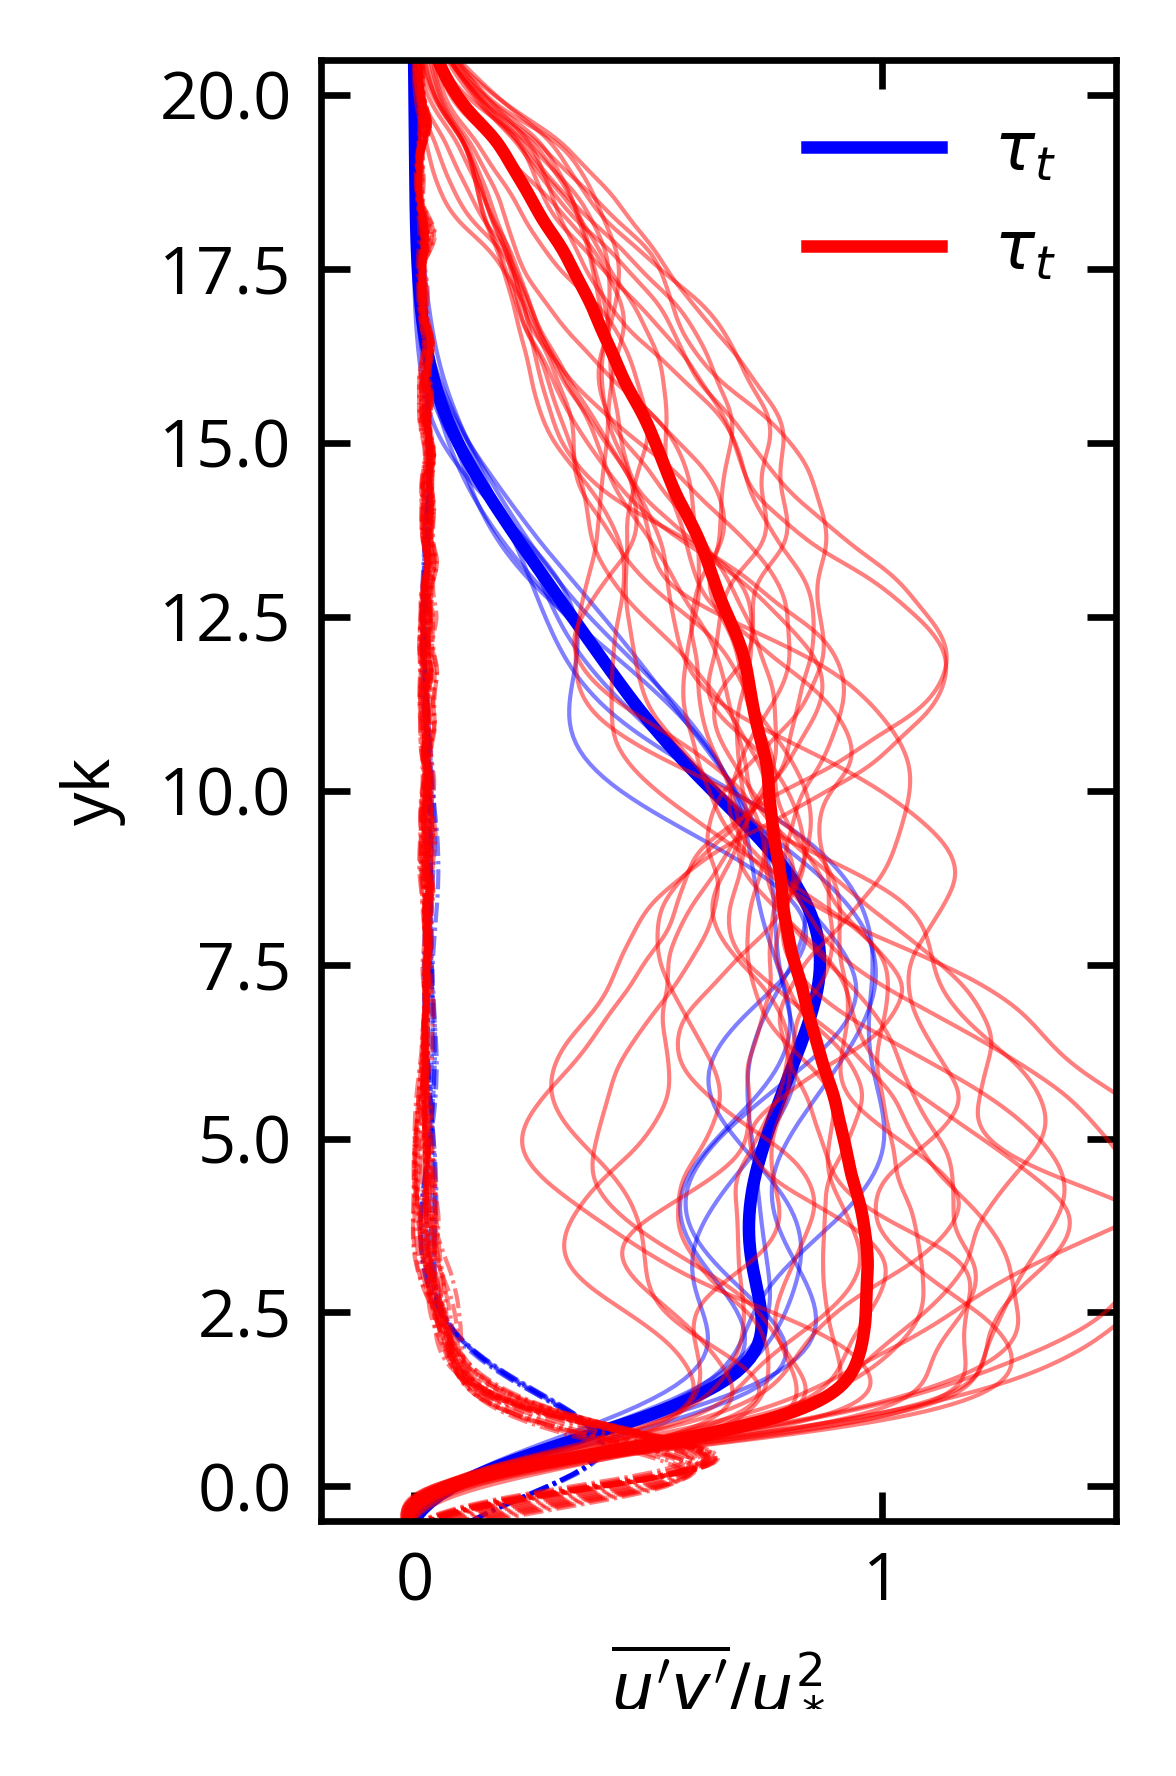

In [46]:
plt.figure(figsize=(2,3))
L0 = 2*np.pi; k = 4
nu_a = nu_a = 0.25*(2*np.pi-1)/360

re_stress = []
viscous_stress = []
N = 256
yarray = np.linspace(0,L0,N,endpoint=False)+L0/N/2
for i in range(0,7):
    # Reynolds stress
    re_stress_i = -np.average(snapshot_ensemble[i].re_stress_2D, axis=0)
    re_stress_i = butter_lowpass_filter(re_stress_i)
    plt.plot(re_stress_i/0.25**2, (yarray-1)*k, c='blue', alpha=0.5, lw=0.5)
    re_stress.append(re_stress_i)
    # Viscous stress
    ux_i = snapshot_ensemble[i].ux_1D
    ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(yarray[1]-yarray[0])*nu_a
    plt.plot(viscous_stress_i/0.25**2, (yarray-1)*k, '-.', c='blue', alpha=0.5, lw=0.5)
    viscous_stress.append(viscous_stress_i)
plt.plot(np.average(re_stress, axis=0)/0.25**2, (yarray-1)*k, c='blue', label=r'$\tau_t$')

re_stress = []
viscous_stress = []
N = 512
yarray = np.linspace(0,L0,N,endpoint=False)+L0/N/2
for i in range(0,24):
    # Reynolds stress
    re_stress_i = -np.average(snapshot_ensemble_360_moving_MU16[i].re_stress_2D, axis=0)
    re_stress_i = butter_lowpass_filter(re_stress_i)
    plt.plot(re_stress_i/0.25**2, (yarray-1)*k, c='red', alpha=0.5, lw=0.5)
    re_stress.append(re_stress_i)
    # Viscous stress
    ux_i = snapshot_ensemble_360_moving_MU16[i].ux_1D
    ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(yarray[1]-yarray[0])*nu_a
    plt.plot(viscous_stress_i/0.25**2, (yarray-1)*k, '-.', c='red', alpha=0.5, lw=0.5)
    viscous_stress.append(viscous_stress_i)   
plt.plot(np.average(re_stress, axis=0)/0.25**2, (yarray-1)*k, c='red', label=r'$\tau_t$')


# plt.plot(np.average(viscous_stress, axis=0)/0.25**2, (yarray-1)*k, '--', c='blue', label=r'$\tau_{\nu}$')
plt.xlabel('$\overline{u^{\prime} v^{\prime}}/u_*^2$'); plt.ylabel('yk')
plt.legend()
plt.ylim([-0.5,20.5])
plt.xlim([-0.2,1.5])

(-0.2, 1.2)

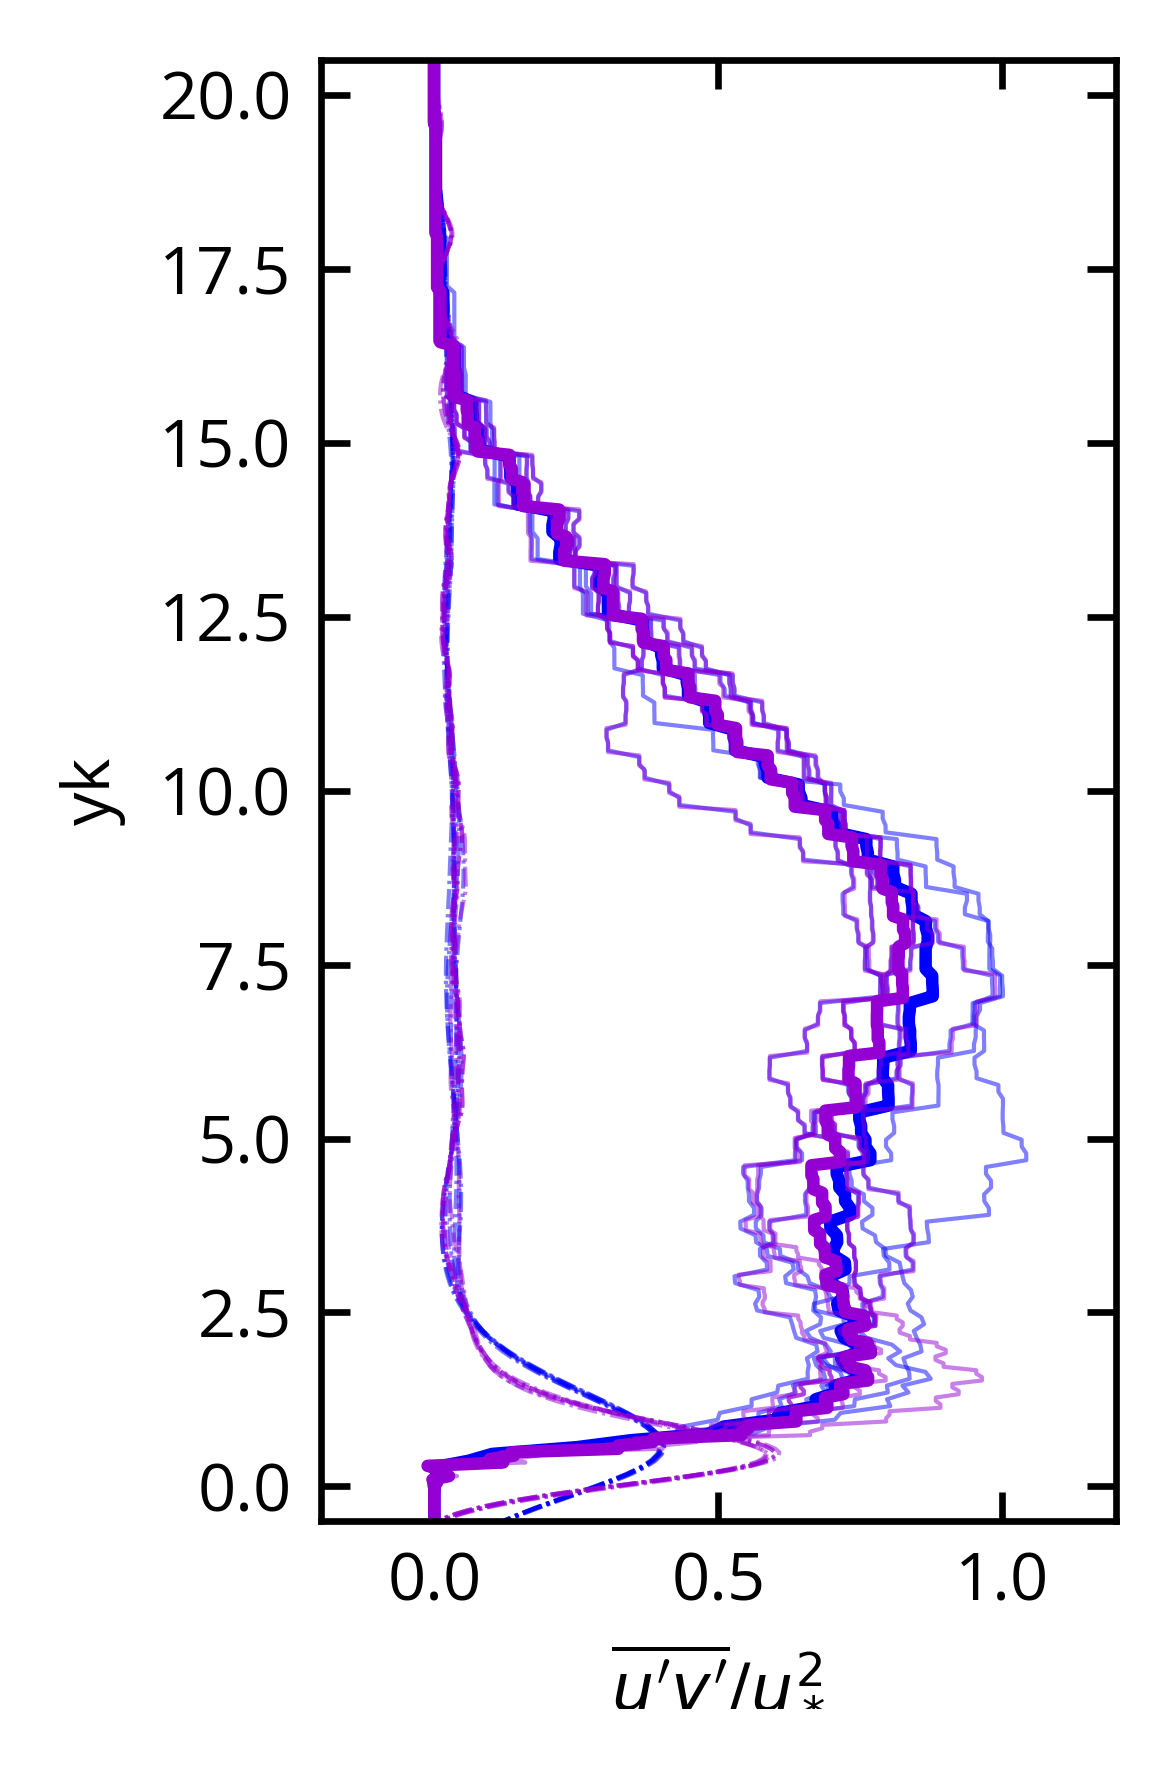

In [41]:
plt.figure(figsize=(2,3))
L0 = 2*np.pi; k = 4
nu_a = nu_a = 0.25*(2*np.pi-1)/360

re_stress = []
viscous_stress = []
N = 256
yarray = np.linspace(0,L0,N,endpoint=False)+L0/N/2
for i in range(0,7):
    # Reynolds stress
    re_stress_i = -np.average(snapshot_ensemble[i].re_stress_2D, axis=0)
#     re_stress_i = butter_lowpass_filter(re_stress_i)
    plt.plot(re_stress_i/0.25**2, (yarray-1)*k, c='blue', alpha=0.5, lw=0.5)
    re_stress.append(re_stress_i)
    # Viscous stress
    ux_i = snapshot_ensemble[i].ux_1D
    ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(yarray[1]-yarray[0])*nu_a
    plt.plot(viscous_stress_i/0.25**2, (yarray-1)*k, '-.', c='blue', alpha=0.5, lw=0.5)
    viscous_stress.append(viscous_stress_i)
plt.plot(np.average(re_stress, axis=0)/0.25**2, (yarray-1)*k, c='blue', label=r'$\tau_t$')

re_stress = []
viscous_stress = []
N = 512
yarray = np.linspace(0,L0,N,endpoint=False)+L0/N/2
for i in range(0,6):
    # Reynolds stress
    re_stress_i = -np.average(snapshot_ensemble_360_10[i].re_stress_2D, axis=0)
#     re_stress_i = butter_lowpass_filter(re_stress_i)
    plt.plot(re_stress_i/0.25**2, (yarray-1)*k, c='darkviolet', alpha=0.5, lw=0.5)
    re_stress.append(re_stress_i)
    # Viscous stress
    ux_i = snapshot_ensemble_360_10[i].ux_1D
    ux_i = butter_lowpass_filter(ux_i)
    viscous_stress_i = np.gradient(ux_i)/(yarray[1]-yarray[0])*nu_a
    plt.plot(viscous_stress_i/0.25**2, (yarray-1)*k, '-.', c='darkviolet', alpha=0.5, lw=0.5)
    viscous_stress.append(viscous_stress_i)
plt.plot(np.average(re_stress, axis=0)/0.25**2, (yarray-1)*k, c='darkviolet', label=r'$\tau_t$')
plt.xlabel('$\overline{u^{\prime} v^{\prime}}/u_*^2$'); plt.ylabel('yk')
plt.ylim([-0.5,20.5])
plt.xlim([-0.2,1.2])

In [248]:
plt.figure(figsize=(2,3))
L0 = 2*np.pi; N = 512; k = 4
nu_a = nu_a = 0.25*(2*np.pi-1)/720
yarray = np.linspace(0,L0,N,endpoint=False)+L0/2**N/2
re_stress_ensemble_aver = np.average(re_stress, axis=(0,1))
re_stress_ensemble_aver = butter_lowpass_filter(re_stress_ensemble_aver, CUT=4)
plt.plot(-re_stress_ensemble_aver/0.25**2, yarray*k, '--', c='blue', label='Reynolds')
# re_stress_ensemble_aver = np.average(re_stress_shift[10:20], axis=(0,1))
# re_stress_ensemble_aver = butter_lowpass_filter(re_stress_ensemble_aver, CUT=4)
# plt.plot(-re_stress_ensemble_aver/0.25**2, case.yarray*case.k, c='red', label='moving wave')
stress_viscous_ensemble = []
for i in range(0,len(re_stress)):
    re_stress_i = butter_lowpass_filter(-np.average(re_stress[i],axis=0))
    plt.plot(re_stress_i/0.25**2, yarray*k, '--', c='blue', alpha=0.5, lw=0.5)
    ux_ensemble_aver = np.average(ux[i], axis=0)
    ux_ensemble_aver = butter_lowpass_filter(ux_ensemble_aver)
    stress_viscous = np.gradient(ux_ensemble_aver)/(yarray[1]-yarray[0])*nu_a
    stress_viscous_ensemble.append(stress_viscous)
    plt.plot(stress_viscous/0.25**2, yarray*k, '-.', c='blue', alpha=0.5, lw=0.5)
plt.plot(np.average(stress_viscous_ensemble,axis=0)/0.25**2, yarray*k, '-.', c='blue', label='viscous')    
#     plt.plot((np.gradient(ux_ensemble_aver)/(case.yarray[1]-case.yarray[0])*case.mu2/case.rho2+re_stress)/0.25**2, case.yarray*case.k,
#              '--', c='blue', alpha=0.5, lw=0.5)
plt.plot((np.average(stress_viscous_ensemble,axis=0)-re_stress_ensemble_aver)/0.25**2, yarray*k, c='blue', label='total')
plt.legend()

IndexError: tuple index out of range

<Figure size 1200x1800 with 0 Axes>

In [ ]:
'''Plotting Reynolds stress (averaged) from diagnosis output'''
plt.figure(figsize=(2,3))
case = case6
# case.mean_profile([250])
re_stress_ensemble_aver = np.average(re_stress_shift[0:10], axis=(0,1))
re_stress_ensemble_aver = butter_lowpass_filter(re_stress_ensemble_aver, CUT=4)
plt.plot(-re_stress_ensemble_aver/0.25**2, case.yarray*case.k, c='blue', label='stationary wave')
re_stress_ensemble_aver = np.average(re_stress_shift[10:20], axis=(0,1))
re_stress_ensemble_aver = butter_lowpass_filter(re_stress_ensemble_aver, CUT=4)
plt.plot(-re_stress_ensemble_aver/0.25**2, case.yarray*case.k, c='red', label='moving wave')
for i in range(0,10):
    re_stress = butter_lowpass_filter(-np.average(re_stress_shift[i],axis=0))
    plt.plot(re_stress/0.25**2, case.yarray*case.k, c='blue', alpha=0.5, lw=0.5)
    ux_ensemble_aver = np.average(ux_shift[i], axis=0)
    ux_ensemble_aver = butter_lowpass_filter(ux_ensemble_aver)
    plt.plot(np.gradient(ux_ensemble_aver)/(case.yarray[1]-case.yarray[0])*case.mu2/case.rho2/0.25**2, case.yarray*case.k,
             '--', c='blue', alpha=0.5, lw=0.5)
#     plt.plot((np.gradient(ux_ensemble_aver)/(case.yarray[1]-case.yarray[0])*case.mu2/case.rho2+re_stress)/0.25**2, case.yarray*case.k,
#              '--', c='blue', alpha=0.5, lw=0.5)
for i in range(10,20):
    re_stress = butter_lowpass_filter(-np.average(re_stress_shift[i],axis=0))
    plt.plot(re_stress/0.25**2, case.yarray*case.k, c='red', alpha=0.5, lw=0.5)
    ux_ensemble_aver = np.average(ux_shift[i], axis=0)
    ux_ensemble_aver = butter_lowpass_filter(ux_ensemble_aver)
    plt.plot(np.gradient(ux_ensemble_aver)/(case.yarray[1]-case.yarray[0])*case.mu2/case.rho2/0.25**2, case.yarray*case.k,
             '--', c='red', alpha=0.5, lw=0.5)
# plt.plot(-re_stress_ensemble_aver/0.25**2, case.yarray*case.k)
# ux_ensemble_aver = np.average(ux_shift, axis=(0,1))
# ux_ensemble_aver = butter_lowpass_filter(ux_ensemble_aver)
# plt.plot(np.gradient(ux_ensemble_aver)/(case.yarray[1]-case.yarray[0])*case.mu2/case.rho2/0.25**2, case.yarray*case.k,
#        label = '\tau_\nu')
plt.ylabel(r'$yk$'); plt.xlabel(r'$-\overline{u^{\prime} v^{\prime}}/u_{*}^{2}$')
plt.xlim([0,1])
plt.legend()

No handles with labels found to put in legend.


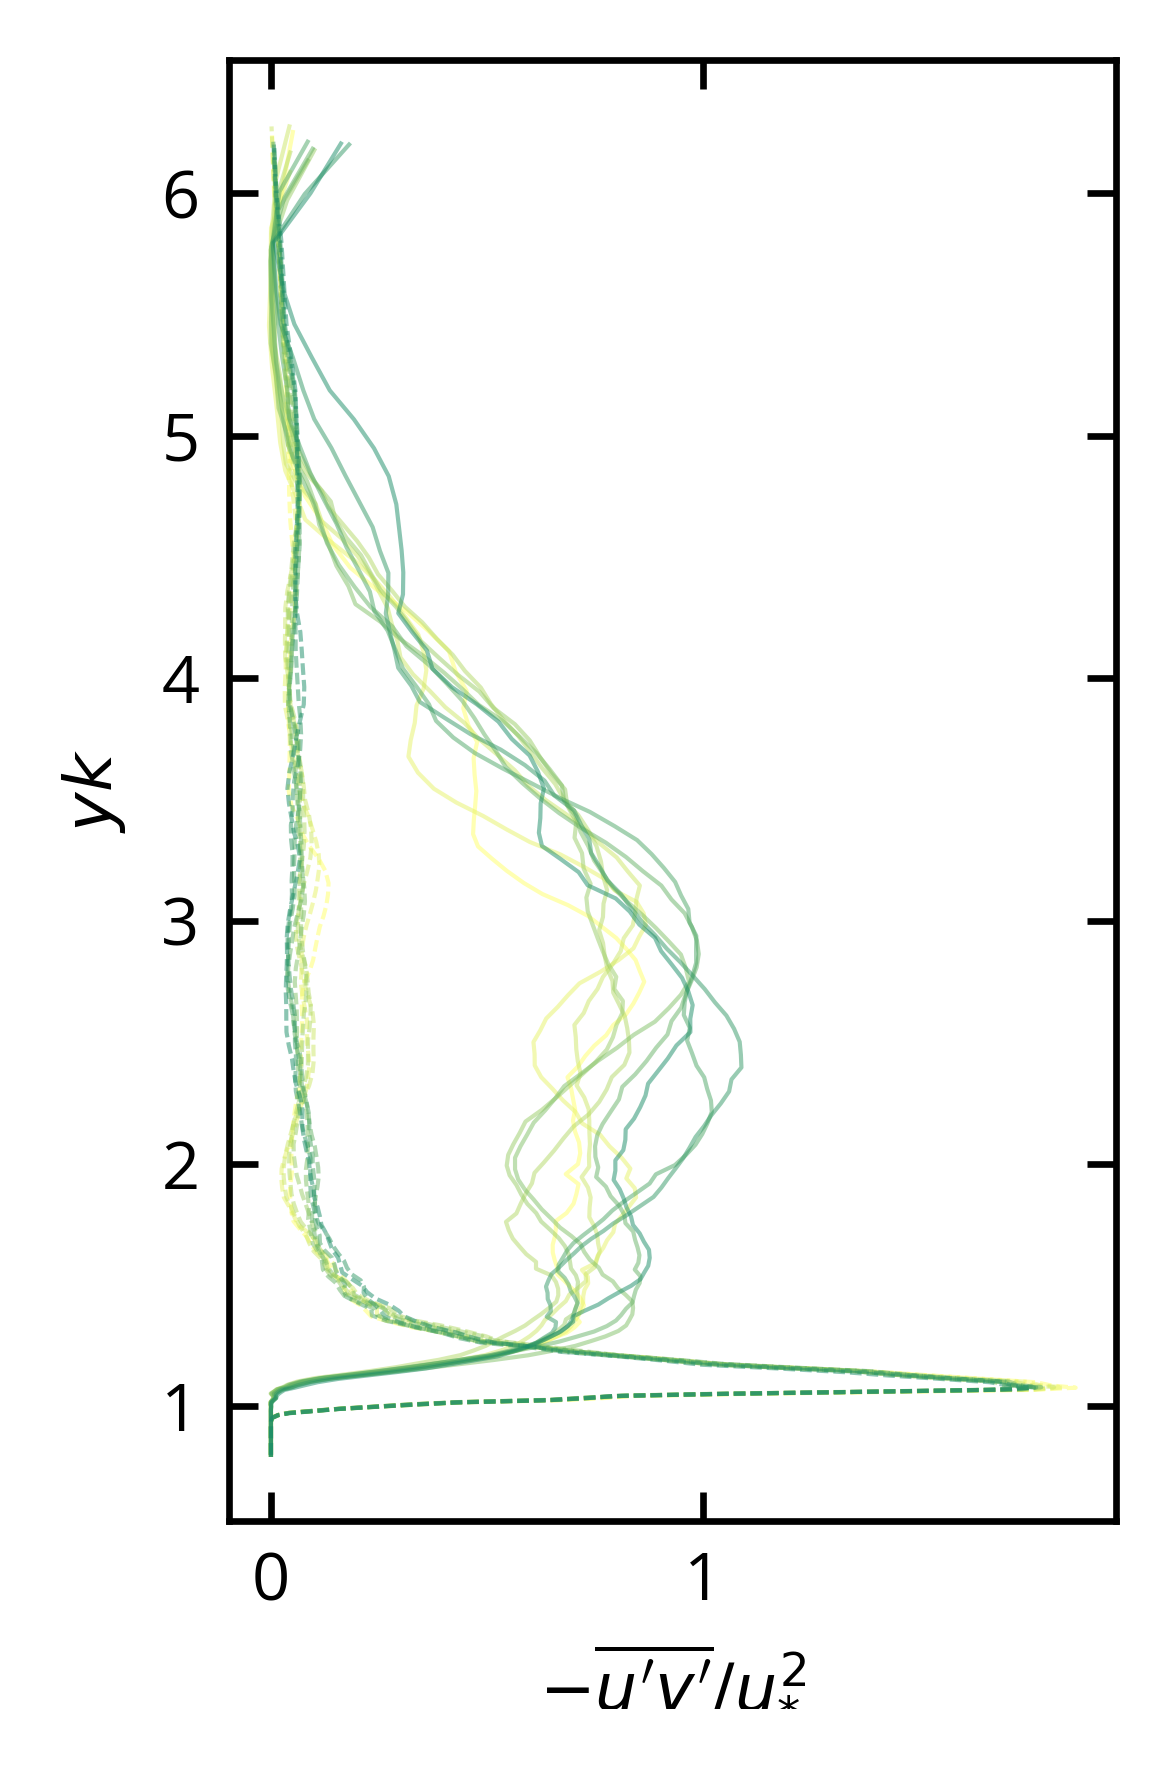

In [35]:
'''Plotting Reynolds stress (averaged) from prof files'''
dirname = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau360_BO200_g4_ak0.2_LEVEL9_emax0.3/'
plt.figure(figsize=(2,3))
u_tau = 0.25
nu_a = 0.25*(2*np.pi-1)/180
for i in range(0,10):
    filename = dirname + 'prof_%g' %(i+60)
    stats = pd.read_table(filename, delimiter = '\t', names = ['y','ux','uy','uz','uxuy','uxux','uyuy','uzuz'], skiprows=[0])    
    plt.plot(-(stats.uxuy-stats.ux*stats.uy)/u_tau**2, stats.y, color=plt.cm.get_cmap('summer')(1-i/10), alpha=0.5, lw=0.5)
#     ux_mean = butter_lowpass_filter(stats.ux)
#     dy = np.gradient(stats.y)
    plt.plot(np.gradient(stats.ux,stats.y)*nu_a/u_tau**2, stats.y,
             '--', color=plt.cm.get_cmap('summer')(1-i/10), alpha=0.5, lw=0.5)
    
#     re_stress = butter_lowpass_filter(-np.average(re_stress_shift[i],axis=0))
#     plt.plot(re_stress/0.25**2, case.yarray*case.k, c='blue', alpha=0.5, lw=0.5)
#     ux_ensemble_aver = np.average(ux_shift[i], axis=0)
#     ux_ensemble_aver = butter_lowpass_filter(ux_ensemble_aver)
#     plt.plot(np.gradient(ux_ensemble_aver)/(case.yarray[1]-case.yarray[0])*case.mu2/case.rho2/0.25**2, case.yarray*case.k,
#              '--', c='blue', alpha=0.5, lw=0.5)
#     plt.plot((np.gradient(ux_ensemble_aver)/(case.yarray[1]-case.yarray[0])*case.mu2/case.rho2+re_stress)/0.25**2, case.yarray*case.k,
#              '--', c='blue', alpha=0.5, lw=0.5)
plt.ylabel(r'$yk$'); plt.xlabel(r'$-\overline{u^{\prime} v^{\prime}}/u_{*}^{2}$')
# plt.xlim([0,1.4])
plt.legend()

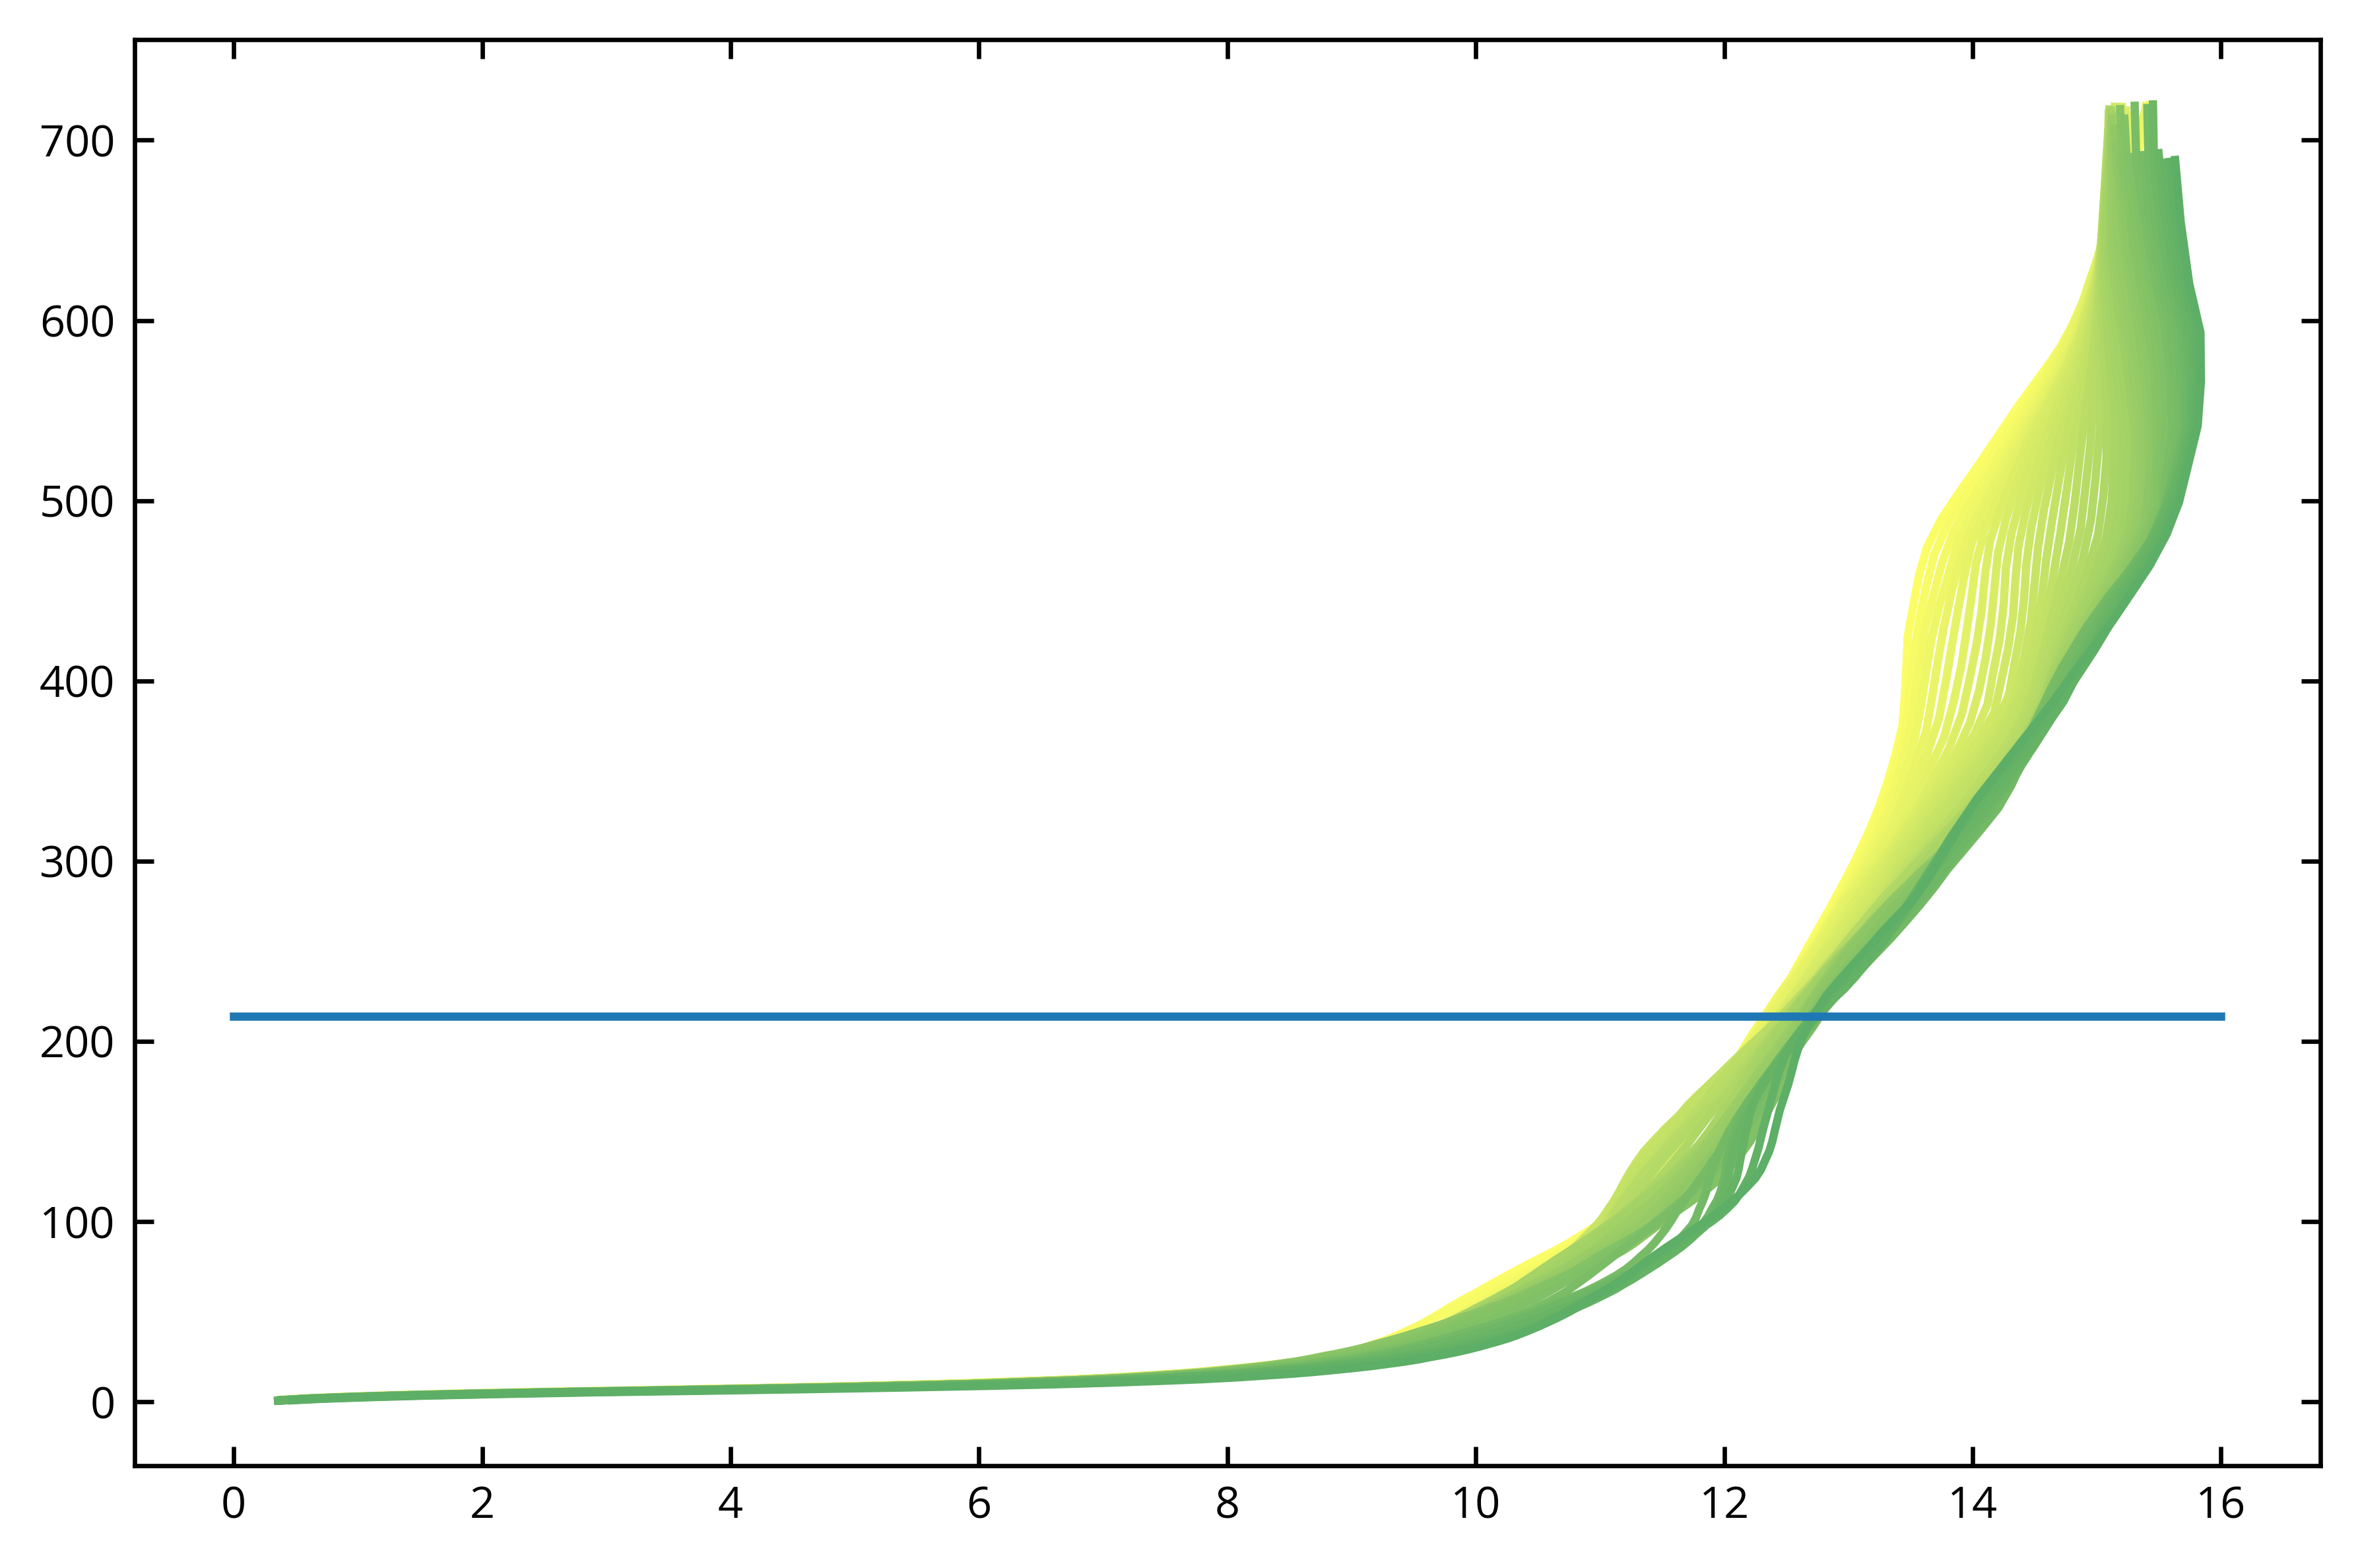

In [96]:
'''Profile file generated on the fly''' 
dirname = '/home/jiarong/research/projects/turbulence/curved_fixREtau_REtau1800_BO10_g4_ak0.1_LEVEL9_emax0.3_precursor/'
fig = plt.figure(figsize=[6,4])
y_tau = (2*np.pi-1)/720; u_tau = 0.25
for i in range(1,39):
    t = 140+i
    filename = dirname + 'prof_%g' %t
    stats = pd.read_table(filename, delimiter = '\t', names = ['y','ux','uy','uz','uxuy','uxux','uyuy','uzuz'], skiprows=[0])    
    # Averaged horizontal velocity
    plt.plot(stats.ux[13:]/u_tau, (stats.y[13:]-1)/y_tau, color=plt.cm.get_cmap('summer')(1-i/60))
    # Reynolds stress
    plt.plot((stats.y-2*np.pi)/(np.pi*2-1), -(stats.uxuy-stats.ux*stats.uy)/u_tau**2, color=plt.cm.get_cmap('summer')(1-i/30))
plt.plot(np.linspace(0,16,100), (np.ones(100)*2*np.pi/4)/y_tau)
# plt.xscale('log')
# plt.ylim([0,20])

In [ ]:
'''Looking at perfs file'''
name = 'perfs_sum.txt'
path = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000_Ustar0.5_ak0.1_LEVEL9_03_refinewater_precursor/'
perfs1,exists = readin(path+name, table_delimiter = ' ', 
                       table_headers = ['t', 'dt', 'mgp_i', 'mgp_nrelax', 'mgpf_i', 'mgpf_nrelax','mgu_i','mgu_nrelax','gridn','perf_t','perf_speed','npe'])
path = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000_Ustar0.5_ak0.1_LEVEL9_04_refinewater_precursor/'
perfs2,exists = readin(path+name, table_delimiter = ' ', 
                       table_headers = ['t', 'dt', 'mgp_i', 'mgp_nrelax', 'mgpf_i', 'mgpf_nrelax','mgu_i','mgu_nrelax','gridn','perf_t','perf_speed','npe'])
path = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000_Ustar0.5_ak0.1_LEVEL9_05_refinewater_precursor/'
perfs3,exists = readin(path+name, table_delimiter = ' ', 
                       table_headers = ['t', 'dt', 'mgp_i', 'mgp_nrelax', 'mgpf_i', 'mgpf_nrelax','mgu_i','mgu_nrelax','gridn','perf_t','perf_speed','npe'])
path = '/home/jiarong/research/projects/turbulence/curved_uniform_forcing_moving_RE10000_Ustar0.5_ak0.1_LEVEL10_05_refinewater_precursor/'
perfs4,exists = readin(path+name, table_delimiter = ' ', 
                       table_headers = ['t', 'dt', 'mgp_i', 'mgp_nrelax', 'mgpf_i', 'mgpf_nrelax','mgu_i','mgu_nrelax','gridn','perf_t','perf_speed','npe'])
plt.plot(perfs1.t,perfs1.gridn,label='LEVEL9,uemax=0.3')
plt.plot(perfs2.t,perfs2.gridn,label='LEVEL9,uemax=0.4')
plt.plot(perfs3.t,perfs3.gridn,label='LEVEL9,uemax=0.5')
plt.plot(perfs4.t,perfs4.gridn,label='LEVEL10,uemax=0.5')
a = np.arange(38,70,0.1)
plt.plot(a,np.ones(a.size)*256**3,'--', color='gray',label='2^8^3')
plt.plot(a,np.ones(a.size)*512**3,'--', color='gray',label='2^9^3')
# plt.plot(a,np.ones(a.size)*512**3,'--', color='gray')
plt.yscale('log')
plt.legend(loc = 'upper right')
plt.ylabel('grid #')